In [1]:
from typing import List, Union
import math
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
import os
from datetime import datetime
import time
import warnings
warnings.simplefilter('ignore')
import pickle
import numpy as np
from numpy.random import seed, randint
import pandas as pd
import six
import sys
sys.modules['sklearn.externals.six'] = six
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, PrecisionRecallDisplay, confusion_matrix, precision_recall_curve, auc, roc_curve, RocCurveDisplay
import joblib

# Data Preparation

This section outlines the steps taken to turn the raw census data in the form of a CSV (comma separated value) into a more refined and manageable structure, namely the Pandas DataFrame.  A DataFrame is simply a tabular data object similar to what you would find in an excel file, with columns names and row values.  The data preparation steps include:

- Reading the raw data CSV file with Pandas and storing it as a DataFrame
- Inhaling the provided metadata, which contains the column names
- Parsing the column names out of the metadata and applying them to our DataFrame
- Identifying if and how many null values are contained in the dataset
- Some light feature engineering is performed, including combining the capital gain/loss columns into one "capital_change" column
- The data is split into "X" and "y" tables, corresponding to the feature data and target data.  This split is performed on the "training" and "test" sets.  More info on these sets later.
- I also provide the option to save these tables with the method "pickle_data"

In [2]:
class DataPrep:

    df: pd.DataFrame
    X_train: pd.DataFrame
    y_train: pd.Series
    X_test: pd.DataFrame
    y_test: pd.Series

    metadata: str
    col_names: List[str]

    def __init__(self, data_path: str):
        self.data_path = data_path

    def create_dataframe(self, display_=False):
        self.df = pd.read_csv(self.data_path, header=None)
        if display_:
            display(self.df.head(3))

    def inhale_metadata(self):
        with open('./census_data/census_income_metadata.txt', 'r') as f:
            self.metadata = f.read()

    def get_col_names(self, display_=False):
        self.col_names = [attr.split(':')[0] for attr in self.metadata.split('- 50000, 50000+.')[1].strip().split('\n')]
        self.col_names.remove('| instance weight'), self.col_names.append('target')
        if display_:
            print(self.col_names)

    def set_col_names(self, display_=False):
        self.df.columns = self.col_names
        if display_:
            display(self.df.head())

    def feature_engineering(self, display_=True):
        """metadata indicated this feature should be dropped"""
        self.df.drop('instance weight', axis=1, inplace=True)
        if display_: print('Instance weight column dropped as per the metadata notes.')

        """a single individual can't have both a capital gain AND a capital loss so condense those"""
        df_cols_before = set(self.df.columns)
        self.df['capital_change'] = self.df['capital gains'] - self.df['capital losses']
        self.df.drop(['capital gains', 'capital losses'], axis=1, inplace=True)
        df_cols_after = set(self.df.columns)
        if display_: print(f'Capital change transformation columns affected: {df_cols_before^df_cols_after}')

        """replace the target feature string values with integers"""
        if display_: print(f'Before target column transformation:\n{self.df["target"].head()}')
        self.df['target'].replace({' - 50000.': 0, ' 50000+.': 1}, inplace=True)
        if display_: print(f'After target column transformation:\n{self.df["target"].head()}')

    def split_X_y(self, phase: str):
        setattr(self, f'y_{phase}', self.df['target'])
        setattr(self, f'X_{phase}', self.df.drop('target', axis=1))

    def apply_all(self, phase: str, pickle_: bool=False):
        self.create_dataframe()
        self.inhale_metadata()
        self.get_col_names()
        self.set_col_names()
        self.feature_engineering(display_=False)
        self.split_X_y(phase)
        if pickle_: self.pickle_data(phase)

    def pickle_data(self, phase: str):
        if 'pickles' not in os.listdir(os.getcwd()): os.mkdir('./pickles')

        for df in ['X', 'y']:
            with open(f'./pickles/{df}_{phase}.obj', 'wb') as f:
                pickle.dump(getattr(self, f'{df}_{phase}'), f)

Read in the data from CSV file and store as Pandas DataFrame, preview the first few entries

In [3]:
data_prep = DataPrep('./census_data/census_income_learn.csv')
data_prep.create_dataframe(display_=True)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.


Need to establish column names that we can reference, which are found in the metadata file

In [4]:
data_prep.inhale_metadata()
data_prep.get_col_names(display_=True)

['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'instance weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 'veterans benefits', 'week

Now that we have the column names, let's set them in the DataFrame and preview to ensure everything worked correctly

In [5]:
data_prep.set_col_names(display_=True)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


The DataFrame "info" method provides a quick and easy inspection of the null values contained in the data and the data types for each feature

In [6]:
data_prep.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital stat                                199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

The first bit of feature engineering we will conduct are dropping the "instance weight" column, consolidating the capital gain/loss columns, and renaming the target values

In [7]:
data_prep.feature_engineering()

Instance weight column dropped as per the metadata notes.
Capital change transformation columns affected: {'capital losses', 'capital gains', 'capital_change'}
Before target column transformation:
0     - 50000.
1     - 50000.
2     - 50000.
3     - 50000.
4     - 50000.
Name: target, dtype: object
After target column transformation:
0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64


Lastly, we want to split the data into "input" and "output" datasets, or "X" and "y" in common data science parlance.  This transformation will be done on both the train dataset...

In [8]:
data_prep.split_X_y(phase='train')
display(data_prep.X_train.head())

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,capital_change
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0


In [9]:
display(data_prep.y_train.head())

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

... and again on the test dataset

In [10]:
test_data_prep = DataPrep('./census_data/census_income_test.csv')
test_data_prep.apply_all(phase='test')
data_prep.X_test, data_prep.y_test = test_data_prep.X_test, test_data_prep.y_test

# Exploratory Data Analysis

Exploratory Data Analysis, more commonly known as "EDA", defines itself: the goal of this task is to gain a deeper understanding of your data, examine feature distributions, try to identify patterns, perform any additional transformations to your data that are required before moving onto modeling.  EDA is very open-ended and highly dependent on your data, there's no "right" or "wrong" way to perform an EDA.  Sometimes there isn't much to examine within the data (e.g. MNIST data) and other times, this process can be exhaustive.  In the case of our census data, there are a lot of categorical features to examine, so this EDA will be on the longer end of the scale.

In [11]:
SMALL_FONT = {'family': 'monospace', 'size': 11}
MEDIUM_FONT = {'family': 'monospace', 'size': 14}
LARGE_FONT = {'family': 'monospace', 'weight': 'bold', 'size': 20 }

class EDA:

    cols_to_scale: List[str] = ['age', 'wage per hour', 'dividends from stocks', 'weeks worked in year', 'capital_change']
    cols_to_encode: List[str] = ['class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 'veterans benefits', 'year']


    def __init__(self, data_prep: DataPrep):
        self.df = data_prep.df
        self.X_train, self.y_train = data_prep.X_train, data_prep.y_train
        self.X_test, self.y_test = data_prep.X_test, data_prep.y_test

    def class_balance(self):
        mpl.rc('font', **MEDIUM_FONT)

        value_counts = self.y_train.value_counts()
        value_counts.index = np.array(['<50k', '>=50k'])

        """print the value counts for each of the class labels and display the values on a chart"""
        print(f'The class counts are:\n{value_counts.to_string()}')

        """create bar chart with class label as x, counts as y"""
        targets, counts = value_counts.index, value_counts.values
        fig, ax = plt.subplots(figsize=(10, 8))
        bar_chart = ax.bar(x=targets, height=counts)

        """calculate class percentages and print them atop each bar"""
        percents = [round(i/len(self.y_train), 2)*100 for i in counts]
        for i, bar in enumerate(bar_chart):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height, percents[i], ha='center', va='bottom')

        plt.title('Count by class label with percentages as text')
        plt.show()

    def show_distributions(self, features: List[str]):
        n_features = len(features)
        n_rows = math.ceil(n_features/4.0)

        k=0
        while n_rows >= 1:
            n_columns = 4 if n_rows > 1 else n_features

            if n_columns > 1:
                fig, ax = plt.subplots(1, n_columns, figsize=(30,10))
                for i in range(n_columns):
                    hist = sns.histplot(x=features[i+k], data=self.X_train[features], ax=ax[i])
                    hist.set_xticklabels(hist.get_xticklabels(), rotation=60, horizontalalignment='right')
            else:
                fig, ax = plt.subplots(figsize=(6,6))
                hist = sns.histplot(x=features[k], data=self.X_train[features], ax=ax)
                hist.set_xticklabels(hist.get_xticklabels(), rotation=60, horizontalalignment='right')

            plt.tight_layout()
            plt.show()

            n_rows -= 1
            n_features -= 4
            k += 4

    def numerical_scaling(self):
        for df in [self.X_train, self.X_test]:
            data_to_scale = df[self.cols_to_scale]
            scaler = StandardScaler()
            data_to_scale = scaler.fit_transform(data_to_scale)
            df[self.cols_to_scale] = data_to_scale

    def examine_cardinality(self, cols: List[str]=None):
        columns = self.df.columns if cols is None else cols
        cardinality_series = pd.Series(index=columns)
        for col in columns:
            cardinality_series.loc[col] = self.df[col].nunique()
        print(cardinality_series.sort_values(ascending=False))

    def categorical_encoding(self, scheme: str = 'target'):
        for df in [(self.X_train, self.y_train), (self.X_test, self.y_test)]:
            if scheme == 'label':
                encoder = LabelEncoder()
                label_encoded = pd.DataFrame(columns=self.cols_to_encode)
                for col in self.cols_to_encode:
                    label_encoded[col] = encoder.fit_transform(df[0][col])
                df[0][self.cols_to_encode] = label_encoded

            elif scheme == 'target':
                encoder = TargetEncoder(cols=self.cols_to_encode)
                encoder.fit(X=df[0][self.cols_to_encode], y=df[1])
                df[0][self.cols_to_encode] = encoder.transform(df[0][self.cols_to_encode])

            else:
                print('Scheme input incorrect. Please input either "label" or "target"')

    def get_val_counts(self, cols: List[str]=None, top_n: int = 8):
        if cols is None: cols = self.df.columns
        for col in cols:
            print(f'{col}: \n{self.df[col].value_counts().iloc[:top_n]}\n')

    def corr_details(self):
        corr = self.X_train.corr()
        describe = corr.describe().transpose()
        
        # pd.set_option('display.precision', 2)
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        pd.set_option('display.colheader_justify', 'center')
        pd.set_option('display.precision', 3)
        print(f'Feature correlation statistics, sorted by mean and standard deviation descending:\n{describe.sort_values(["mean", "std"], ascending=False)}')

        plt.rc('font', size=16)
        plt.figure(figsize=(30, 30))
        sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', vmin=-1,vmax=1,center=0)

        plt.tight_layout()
        plt.show()

In [12]:
eda = EDA(data_prep=data_prep)

The first thing we'll examine if the target column, where we will observe one of the defining characteristics of the task at hand, specifically that we have a very large class imbalance between the negative class (less than $50k in income) vs the positive class (greater than).  This imbalance will need to be addressed before we can begin modeling.  More on this later...

The class counts are:
<50k     187141
>=50k     12382


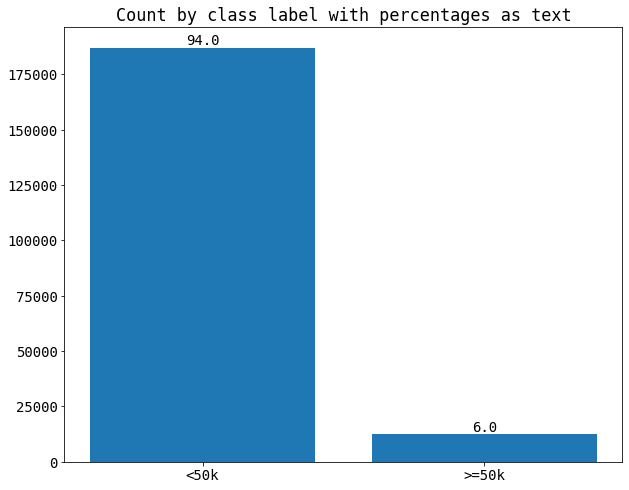

In [13]:
eda.class_balance()

The next thing we will examine is the cardinality of each feature, or in other words, the number of unique values in each of the features.  This will 1) help us determine which features are numerical vs categorical, and 2) give us a first glimpse of how we will want to scale and encode our data.  Don't be fooled by features like "detailed industry recode", all the values are numerals, but they represent a category, not a genuine numerical value.  On the other hand, you can see that there are many unique values for our numerical features like "dividends from stocks" or "wage per hour" because they are genuine numerical values on a continuous scale.

In [14]:
eda.examine_cardinality()

dividends from stocks                         1478.0
wage per hour                                 1240.0
capital_change                                 244.0
age                                             91.0
weeks worked in year                            53.0
detailed industry recode                        52.0
state of previous residence                     51.0
detailed occupation recode                      47.0
country of birth self                           43.0
country of birth mother                         43.0
country of birth father                         43.0
detailed household and family stat              38.0
major industry code                             24.0
education                                       17.0
major occupation code                           15.0
hispanic origin                                 10.0
migration code-move within reg                  10.0
migration code-change in msa                    10.0
class of worker                               

Let's look at the distributions for these numerical values that we will want to scale.  Scaling removes the magnitude differences that are inherent to different features and is very helpful to machine learning models.  Think for a moment about age, wage per hour, and capital change.  One is measured in years and is always positive; meanwhile wage and capital change are both measured in dollars, and is always positive or either positive or negative, respectively.  Scaling removes this ambiguity for the machine.

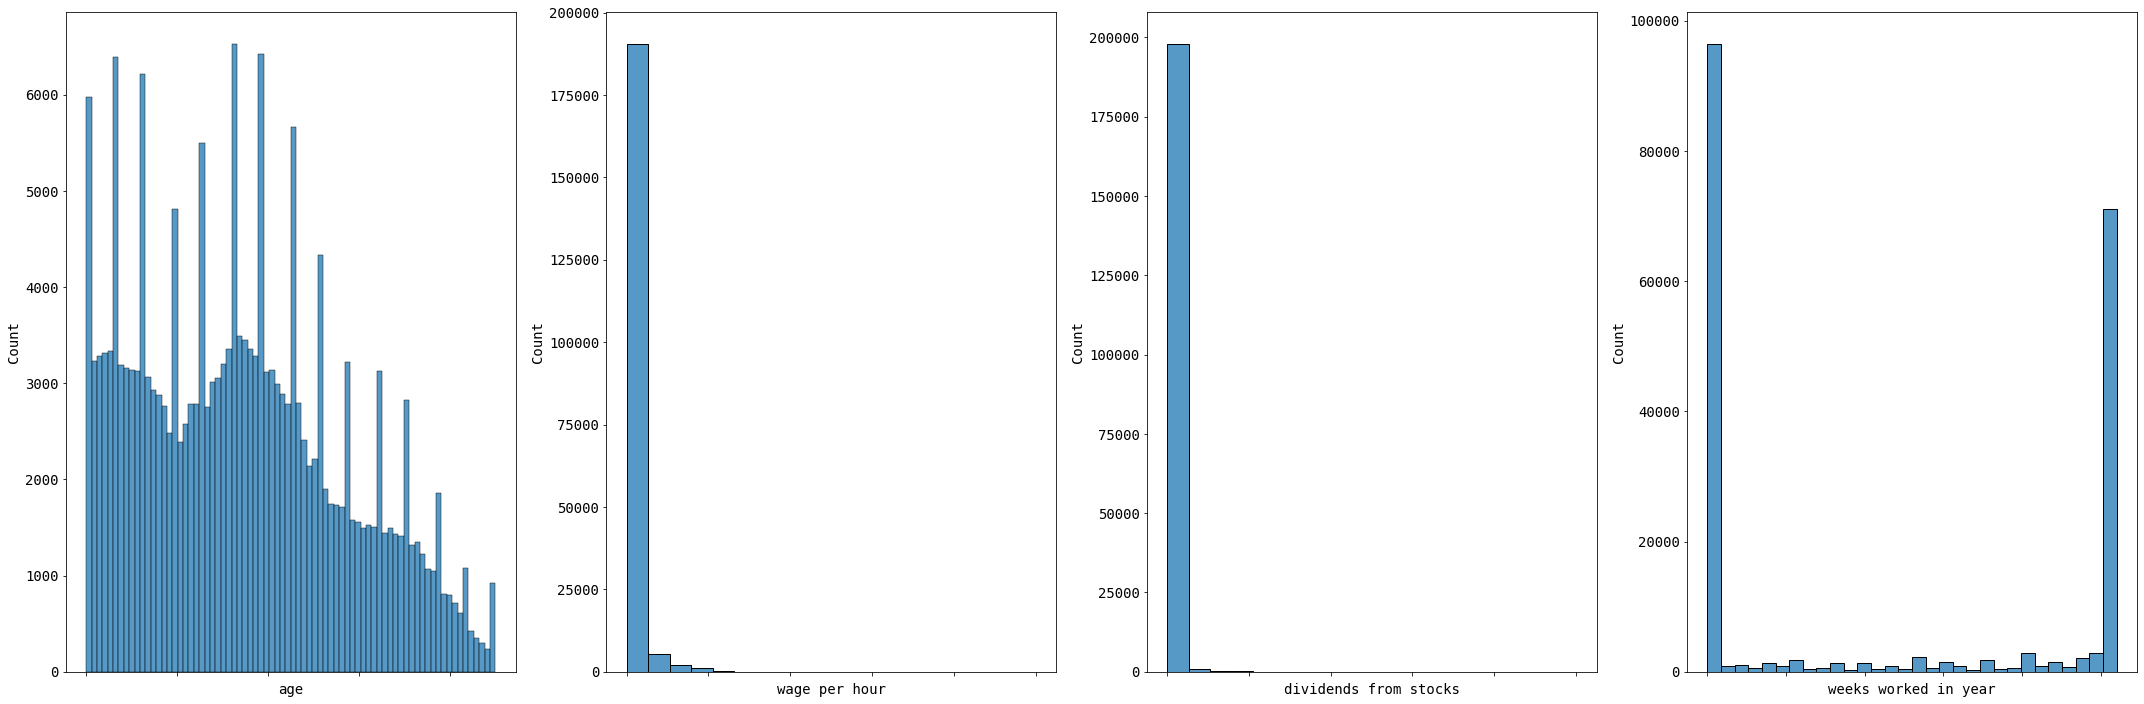

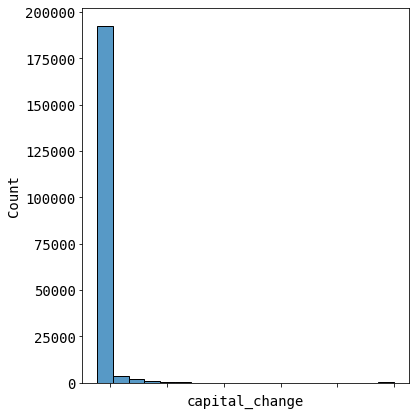

In [15]:
eda.show_distributions(eda.cols_to_scale)

Because of the nature of printing these graphs, here are the top n values for each of the features plotted

In [16]:
eda.get_val_counts(eda.cols_to_scale, top_n=8)

age: 
34    3489
35    3450
36    3353
31    3351
33    3340
5     3332
4     3318
3     3279
Name: age, dtype: int64

wage per hour: 
0       188219
500        734
600        546
700        534
800        507
1000       386
425        376
900        336
Name: wage per hour, dtype: int64

dividends from stocks: 
0       178382
100       1148
500       1030
1000       894
200        866
50         832
2000       574
250        555
Name: dividends from stocks, dtype: int64

weeks worked in year: 
0     95983
52    70314
40     2790
50     2304
26     2268
48     1806
12     1780
30     1378
Name: weeks worked in year, dtype: int64

capital_change: 
 0        188238
 15024       788
 7688        609
 7298        582
-1902        407
 99999       390
-1977        381
-1887        364
Name: capital_change, dtype: int64



For our scaler technique, I chose to use SciKit Learn's standard scaler, which calculates tries to force the feature data into a normal distribution with a mean of 0 and a standard deviation of 1.  Many machine learning models are accustomed to receiving data scaled like this, so most of the time, it's a safe bet to use

In [17]:
eda.numerical_scaling()
eda.X_train.head(3)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,capital_change
0,1.725879,Not in universe,0,0,High school graduate,-0.201629,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,-0.949346,95,-0.084396
1,1.053560,Self-employed-not incorporated,4,34,Some college but no degree,-0.201629,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,1.180804,94,-0.084396
2,-0.739291,Not in universe,0,0,10th grade,-0.201629,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,-0.949346,95,-0.084396


Let's look at the distributions for the remaining categorical that we will want to encode.  Encoding is effectively the bridge from human to machine.  Keep in mind that a machine can only understand numerical values, so we need to "encode" the information contained within our categorical features by transforming them into numbers of some sort.  There are many, many techniques that can be applied to a given dataset, but you want to ensure that you're using the appropriate solution based on the data at hand

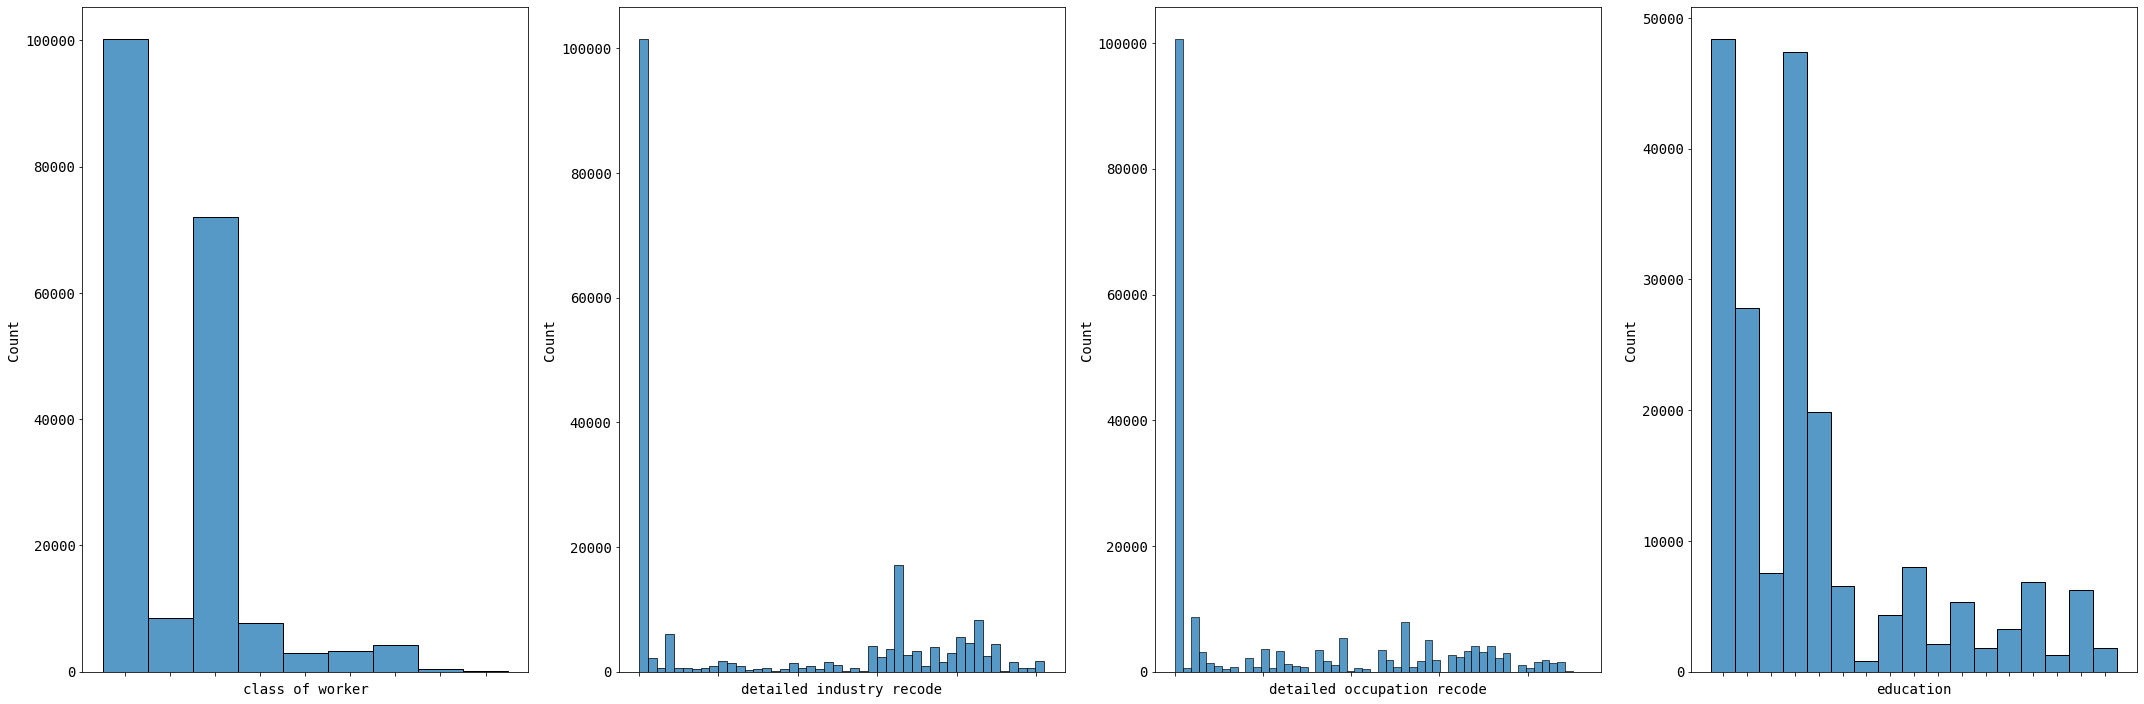

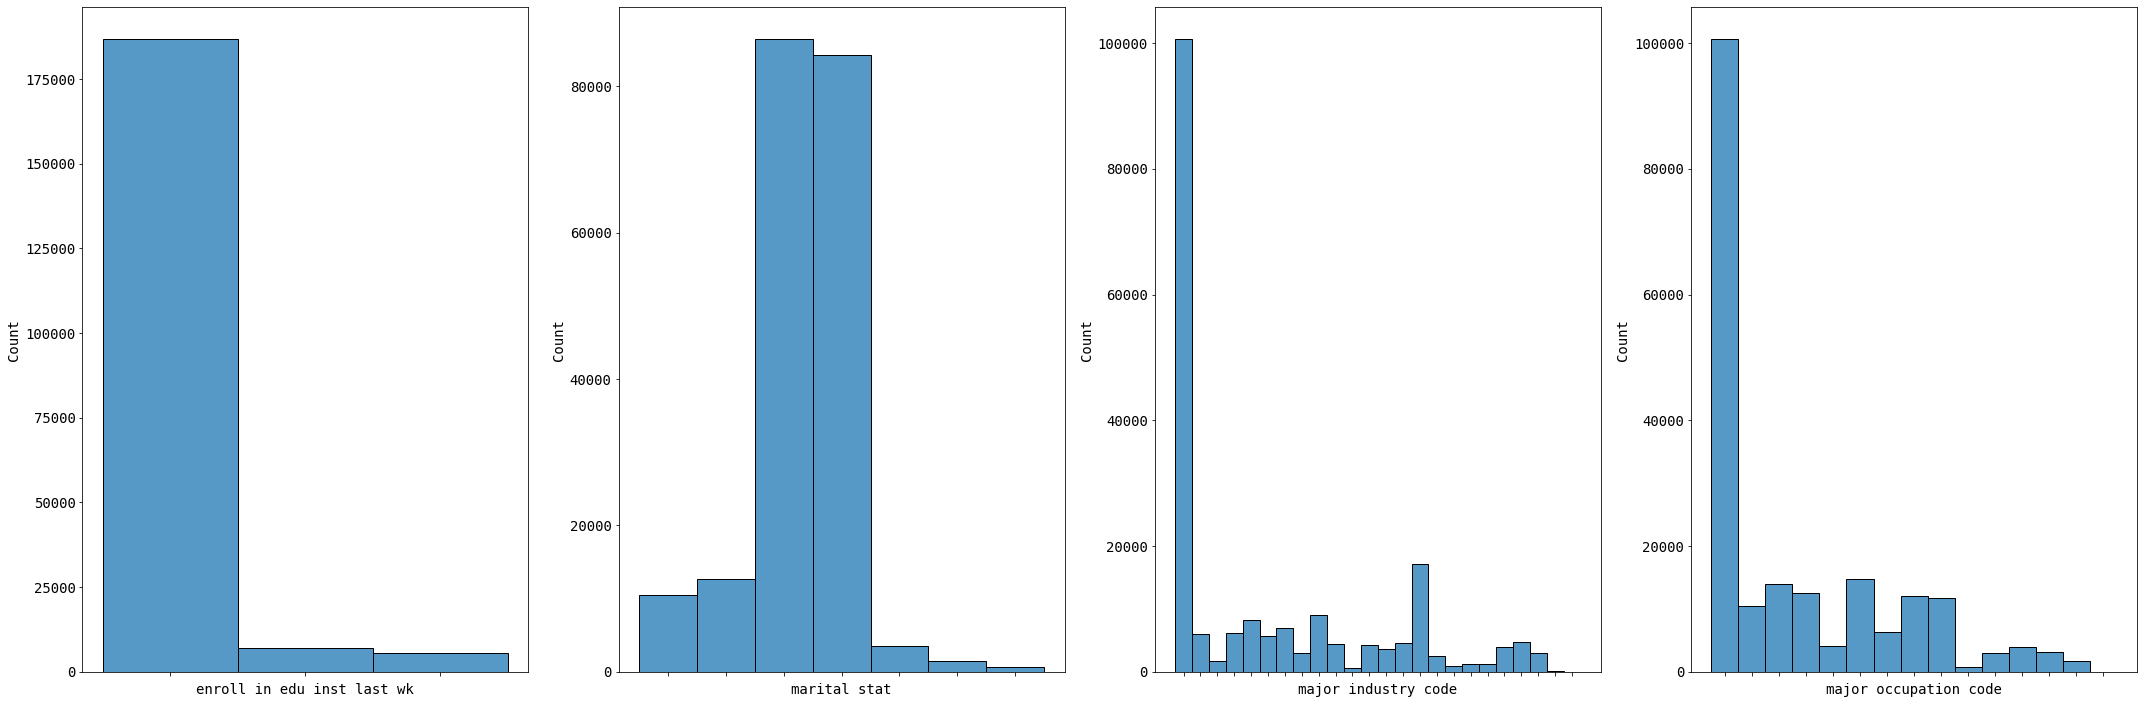

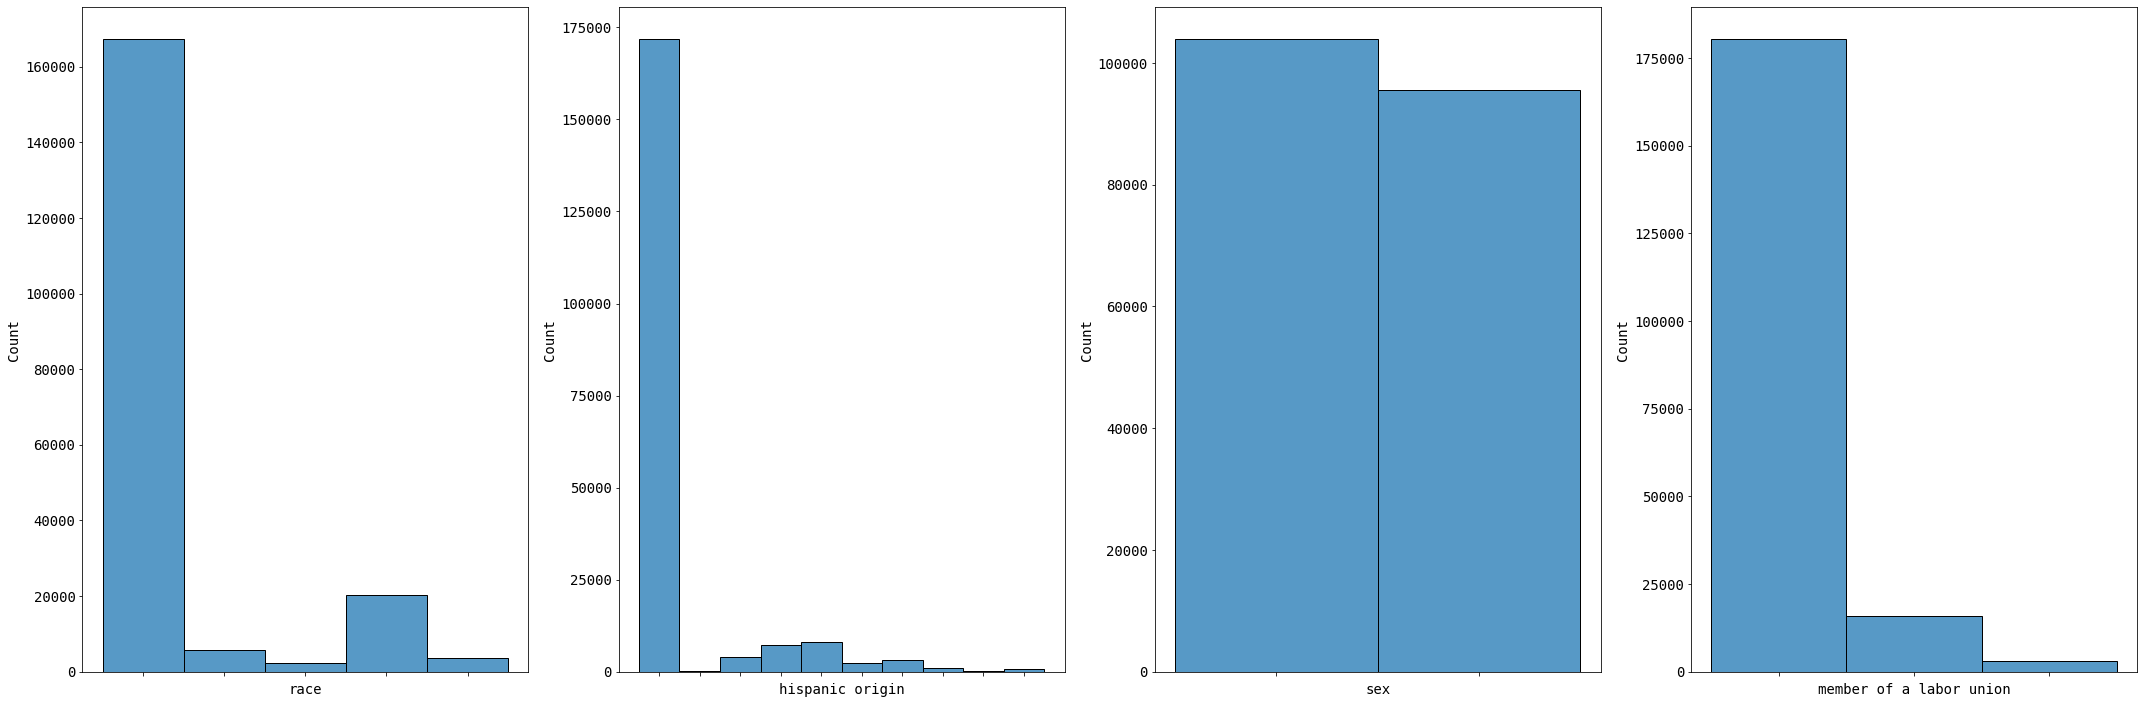

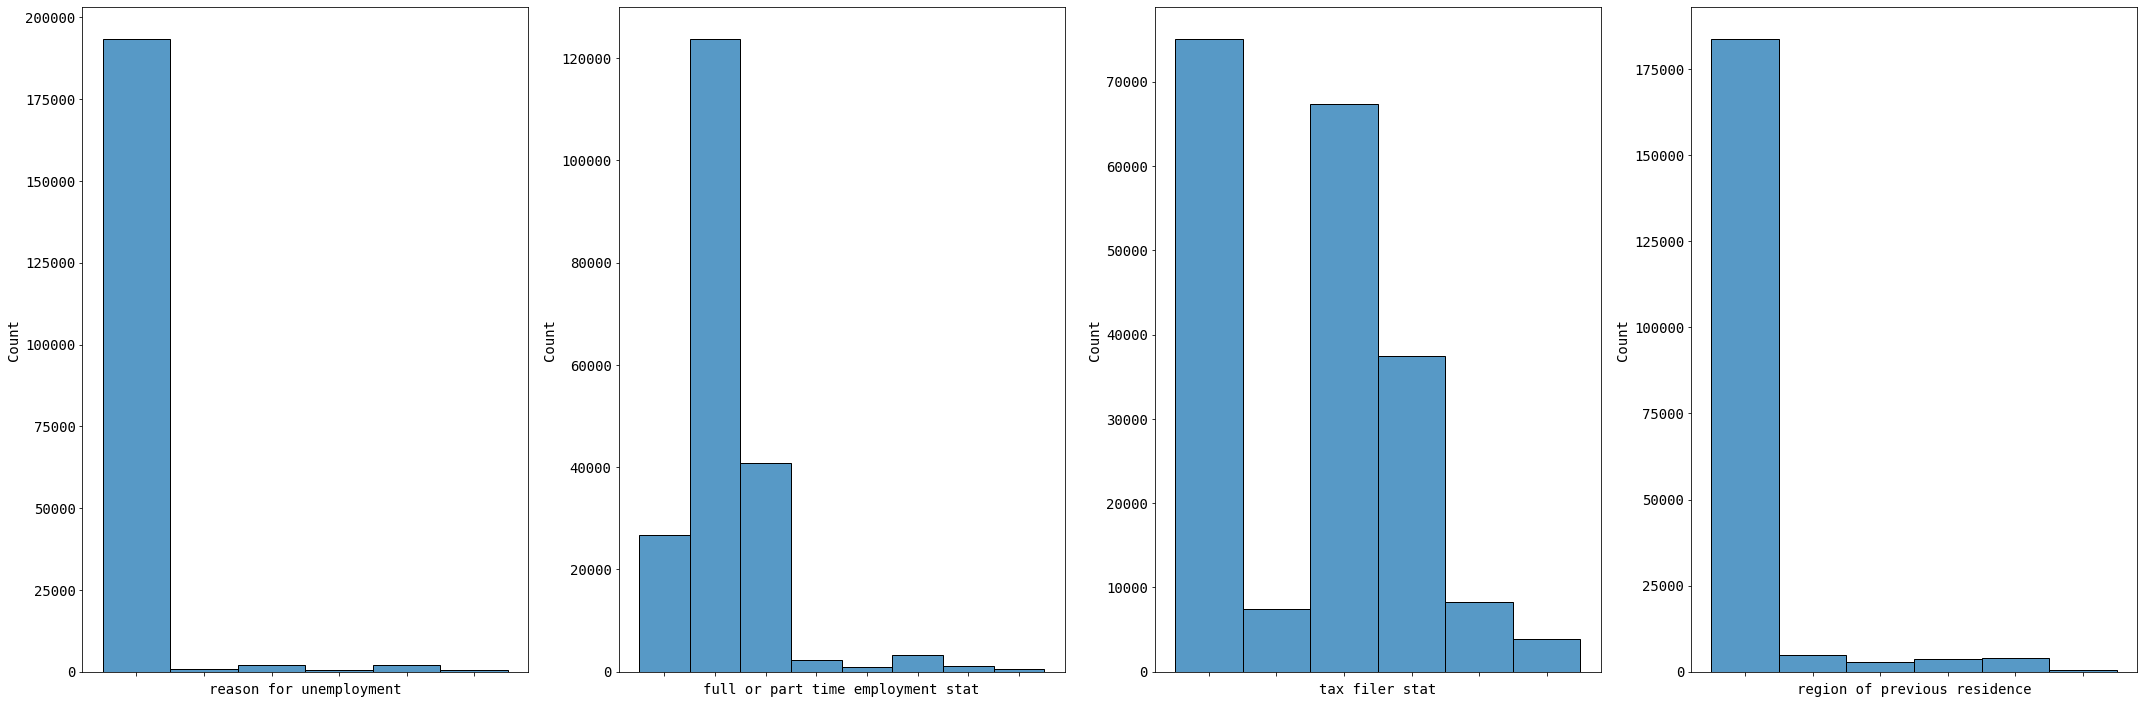

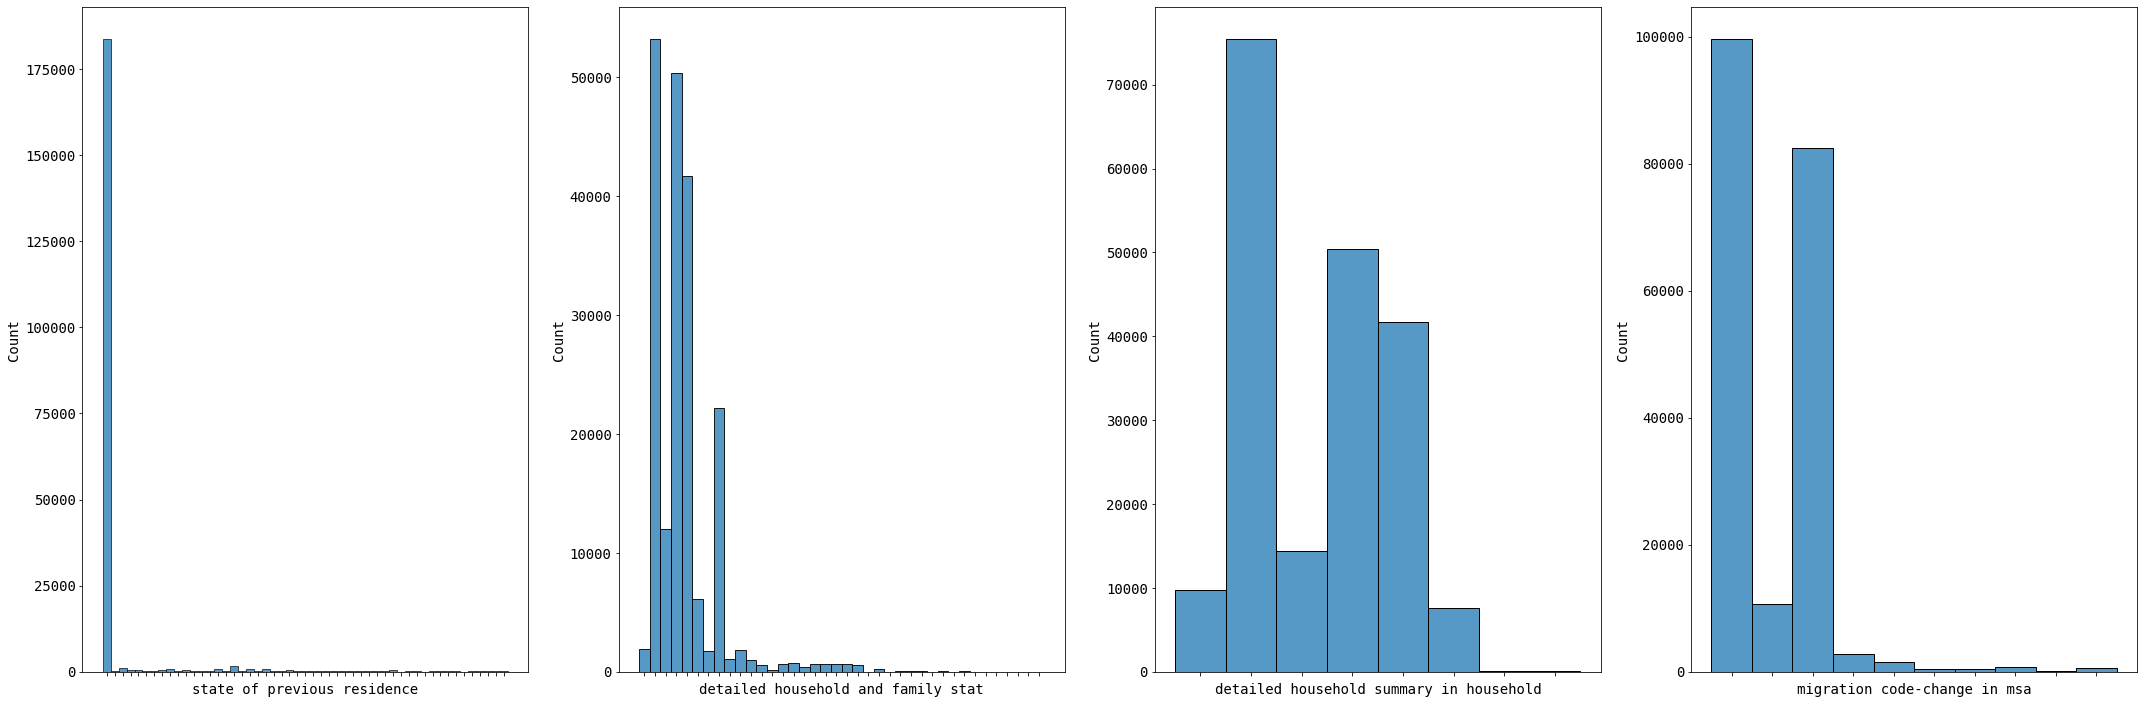

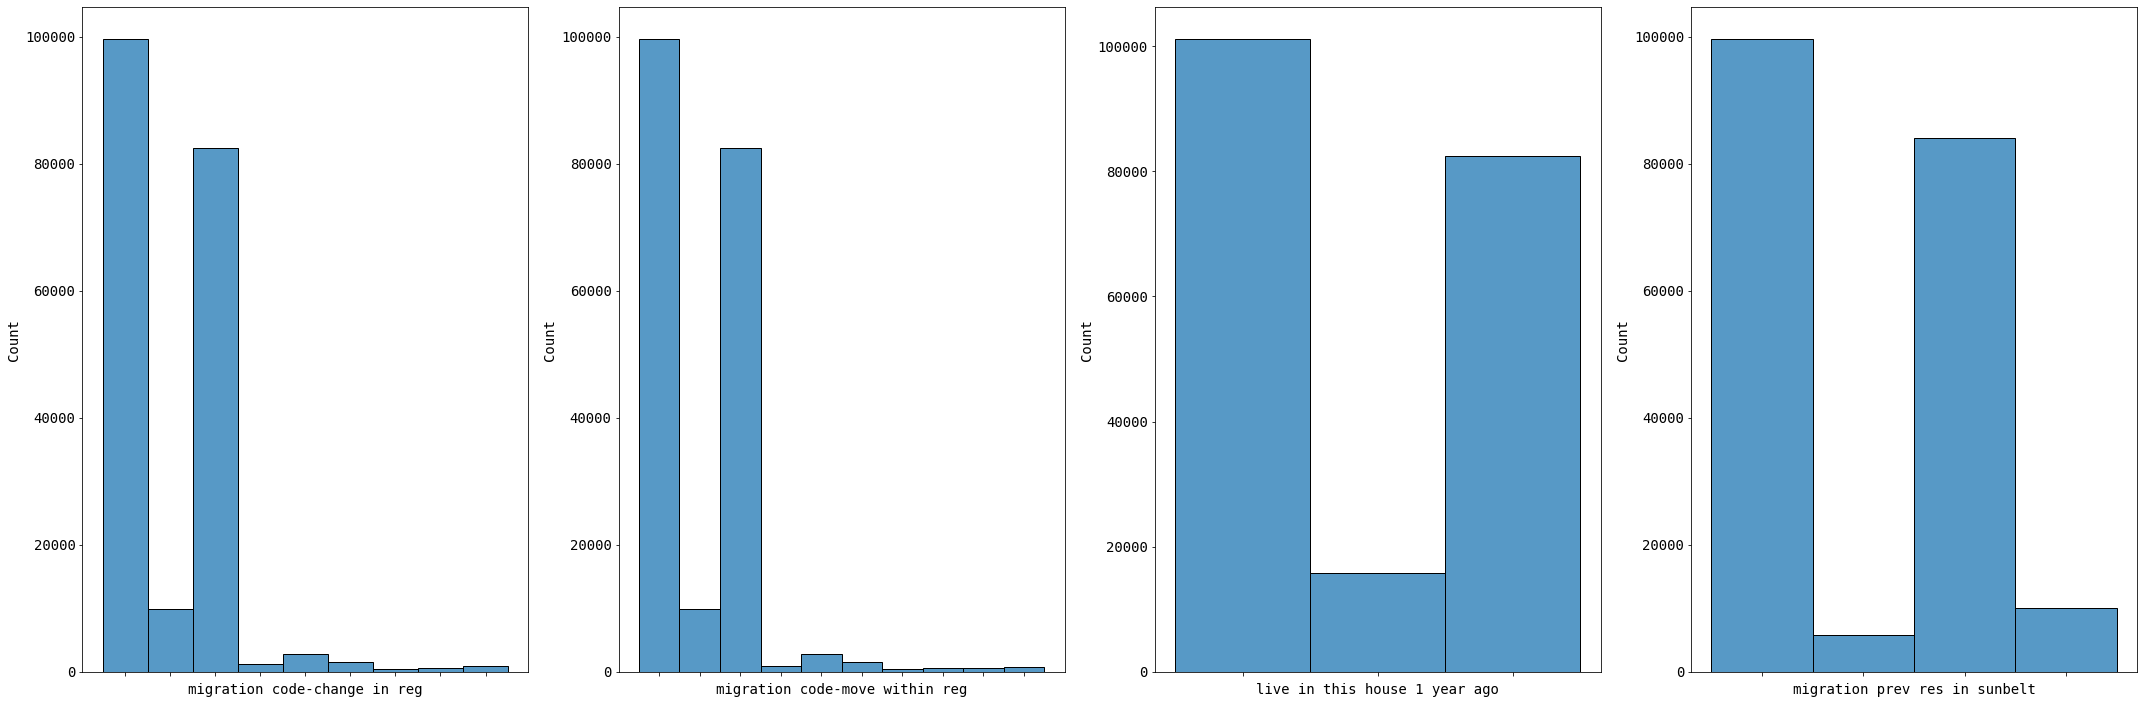

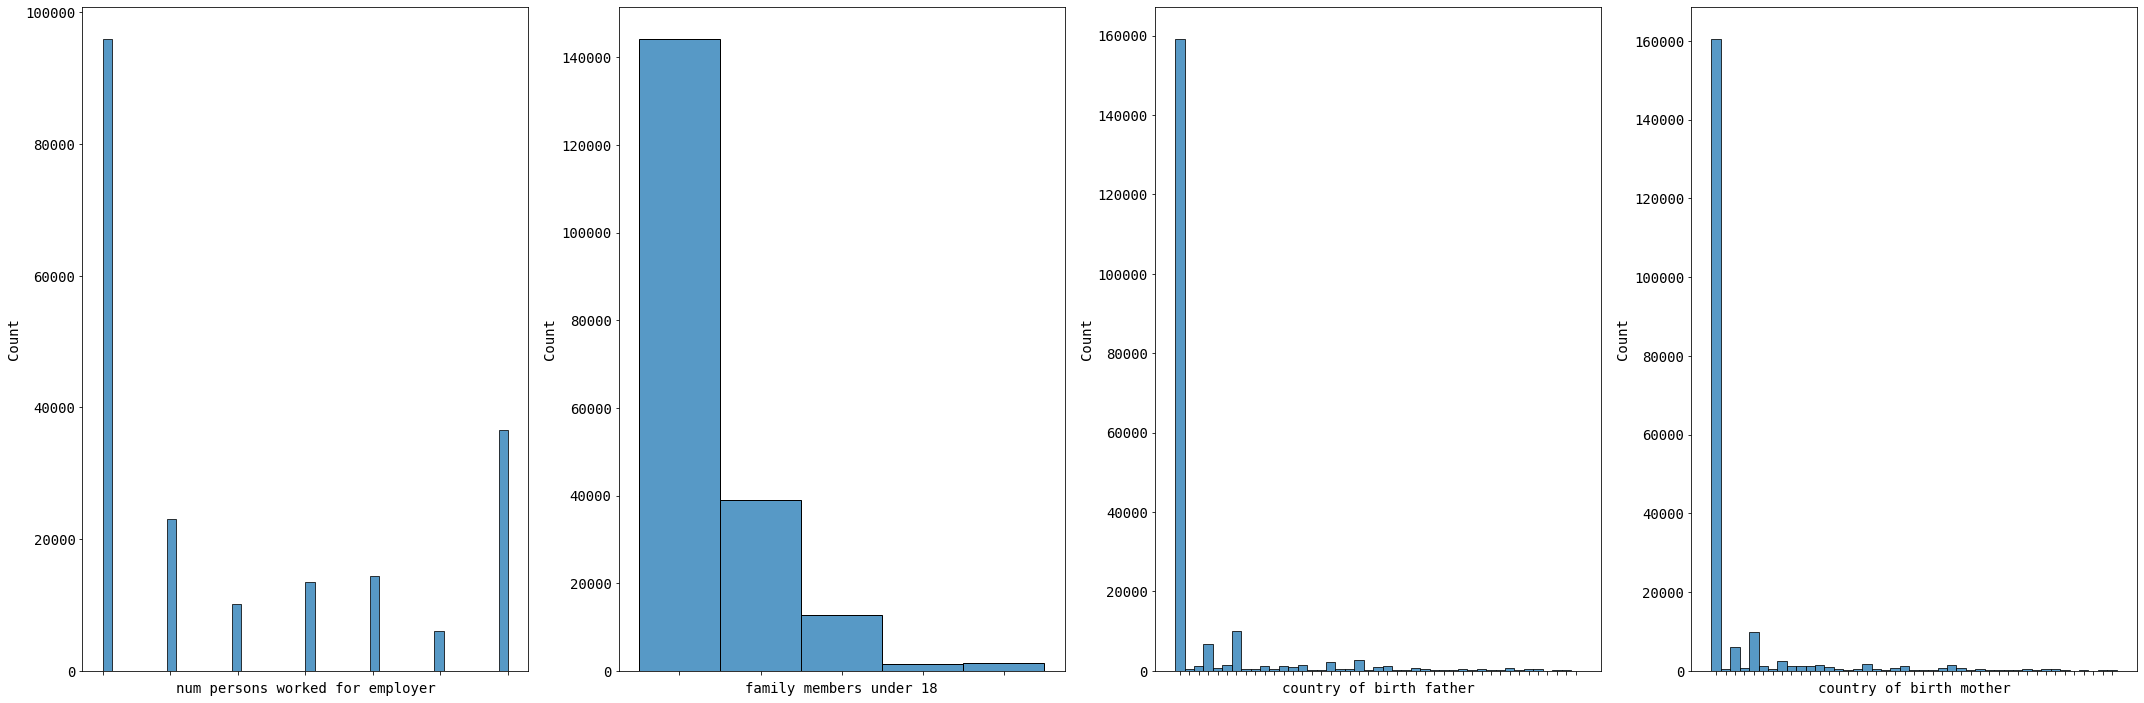

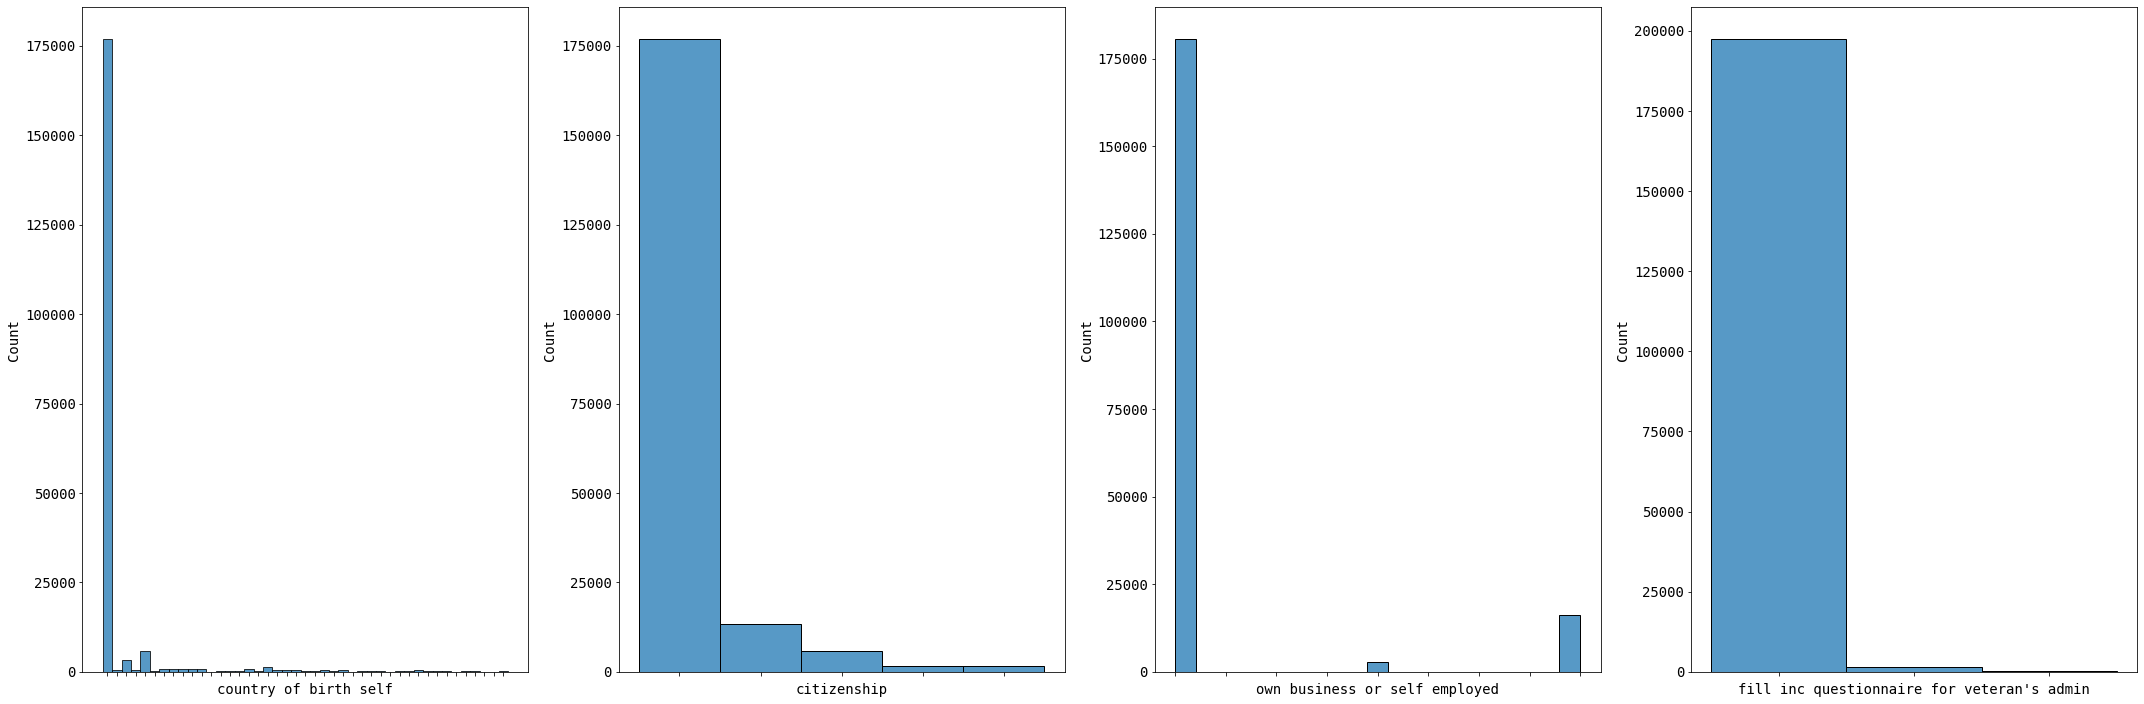

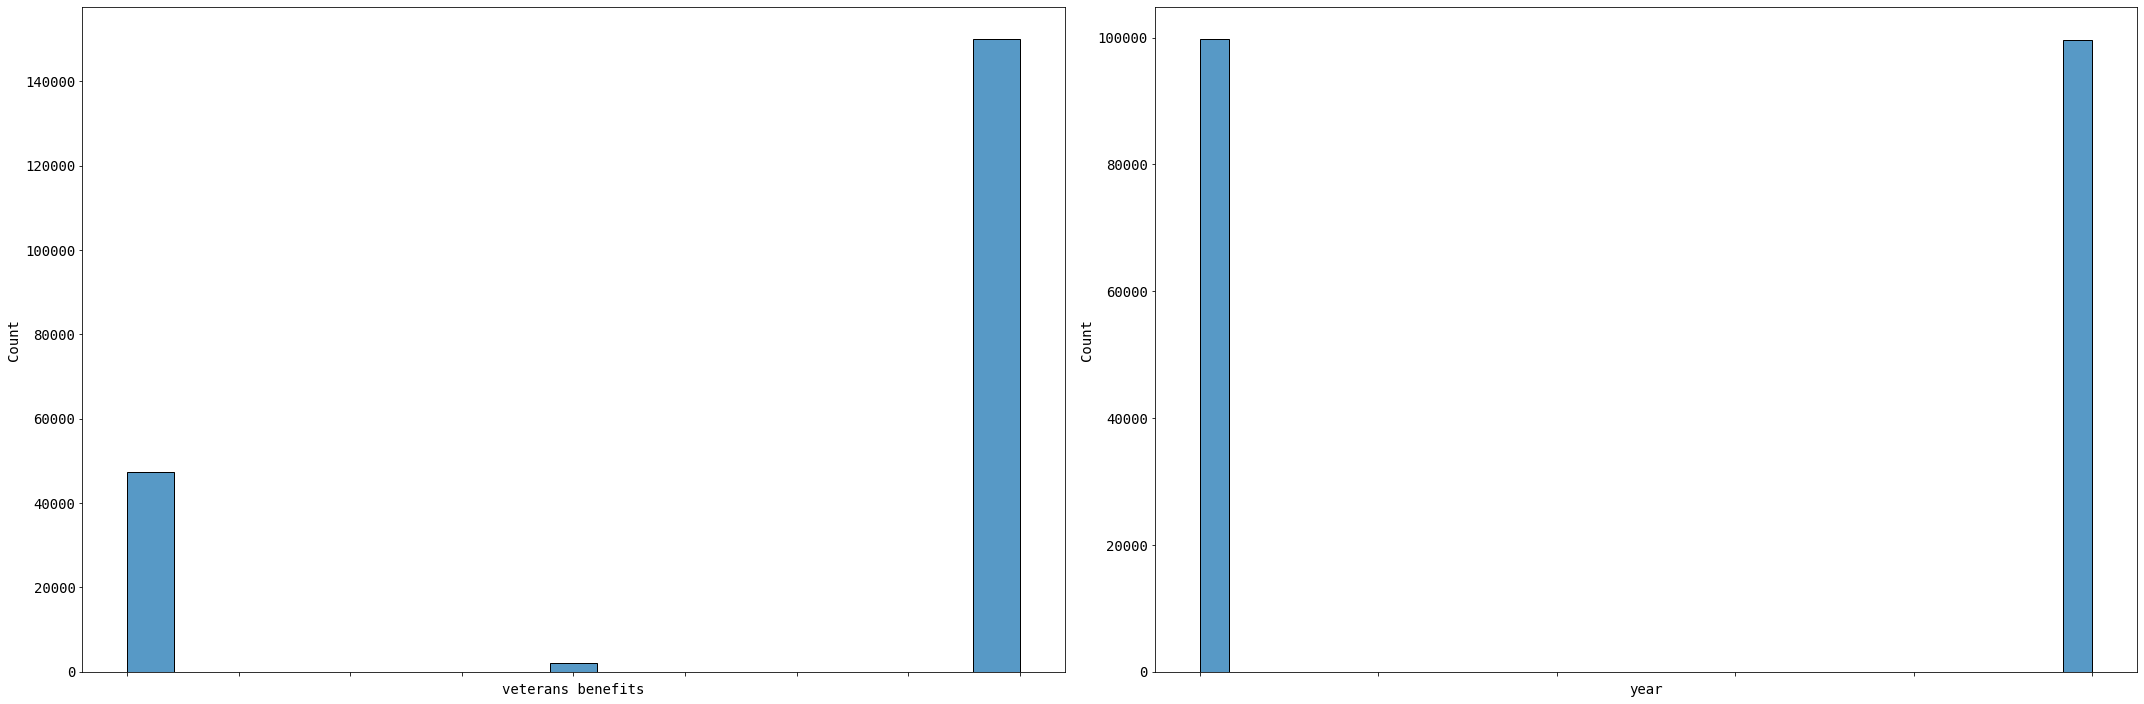

In [18]:
eda.show_distributions(eda.cols_to_encode)

In [19]:
eda.get_val_counts(eda.cols_to_encode)

class of worker: 
 Not in universe                   100245
 Private                            72028
 Self-employed-not incorporated      8445
 Local government                    7784
 State government                    4227
 Self-employed-incorporated          3265
 Federal government                  2925
 Never worked                         439
Name: class of worker, dtype: int64

detailed industry recode: 
0     100684
33     17070
43      8283
4       5984
42      4683
45      4482
29      4209
37      4022
Name: detailed industry recode, dtype: int64

detailed occupation recode: 
0     100684
2       8756
26      7887
19      5413
29      5105
36      4145
34      4025
10      3683
Name: detailed occupation recode, dtype: int64

education: 
 High school graduate                      48407
 Children                                  47422
 Some college but no degree                27820
 Bachelors degree(BA AB BS)                19865
 7th and 8th grade                         

veterans benefits: 
2    150130
0     47409
1      1984
Name: veterans benefits, dtype: int64

year: 
94    99827
95    99696
Name: year, dtype: int64



Because of the substantial prevalence of data that we don't understand (e.g. the plethora of "not in universe" values), I decided to use an encoding technique called "target encoding" or "mean encoding".  This strategy creates a weight for each of the unique values in the feature depending on how often the unique value leads to a positive or negative target.  This technique helps to mitigate the lack of information inherent in these "nearly null" values

In [20]:
eda.categorical_encoding()
eda.X_train.head(3)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,capital_change
0,1.725879,0.009018,0.008998,0.008998,0.038817,-0.201629,0.066074,0.031540,0.008998,0.008998,...,0.064726,0.064731,0.062993,0.062992,0.057851,0.061512,0.080937,-0.949346,0.065630,-0.084396
1,1.053560,0.129070,0.089071,0.074037,0.064234,-0.201629,0.066074,0.083871,0.089071,0.090797,...,0.064726,0.064731,0.062993,0.062992,0.057851,0.061512,0.080937,1.180804,0.058491,-0.084396
2,-0.739291,0.009018,0.008998,0.008998,0.008204,-0.201629,0.000725,0.012916,0.008998,0.008998,...,0.024070,0.023256,0.028133,0.036714,0.057851,0.061512,0.080937,-0.949346,0.065630,-0.084396


The last thing we are going to examine is the correlations of our features to one another.  We want to understand how each feature changes with respect to one another and potentially drop features that are highly correlated.  This will help us avoid the multicollinearity that will lead to poor understandinf of feature importance

Feature correlation statistics, sorted by mean and standard deviation descending:
                                            count  mean    std      min        25%      50%    75%   max
weeks worked in year                        39.0   0.274  0.299 -1.813e-02  3.121e-02  0.110  0.516  1.0
tax filer stat                              39.0   0.270  0.279 -1.910e-03  3.939e-02  0.137  0.524  1.0
family members under 18                     39.0   0.260  0.293 -5.374e-02  5.160e-02  0.081  0.474  1.0
major industry code                         39.0   0.257  0.292 -6.022e-02  2.872e-02  0.110  0.452  1.0
num persons worked for employer             39.0   0.252  0.292 -4.277e-02  1.932e-02  0.078  0.476  1.0
detailed industry recode                    39.0   0.251  0.283 -5.098e-02  3.320e-02  0.109  0.429  1.0
detailed household and family stat          39.0   0.248  0.267 -2.327e-03  6.125e-02  0.102  0.388  1.0
class of worker                             39.0   0.246  0.279 -8.266e-02  2.

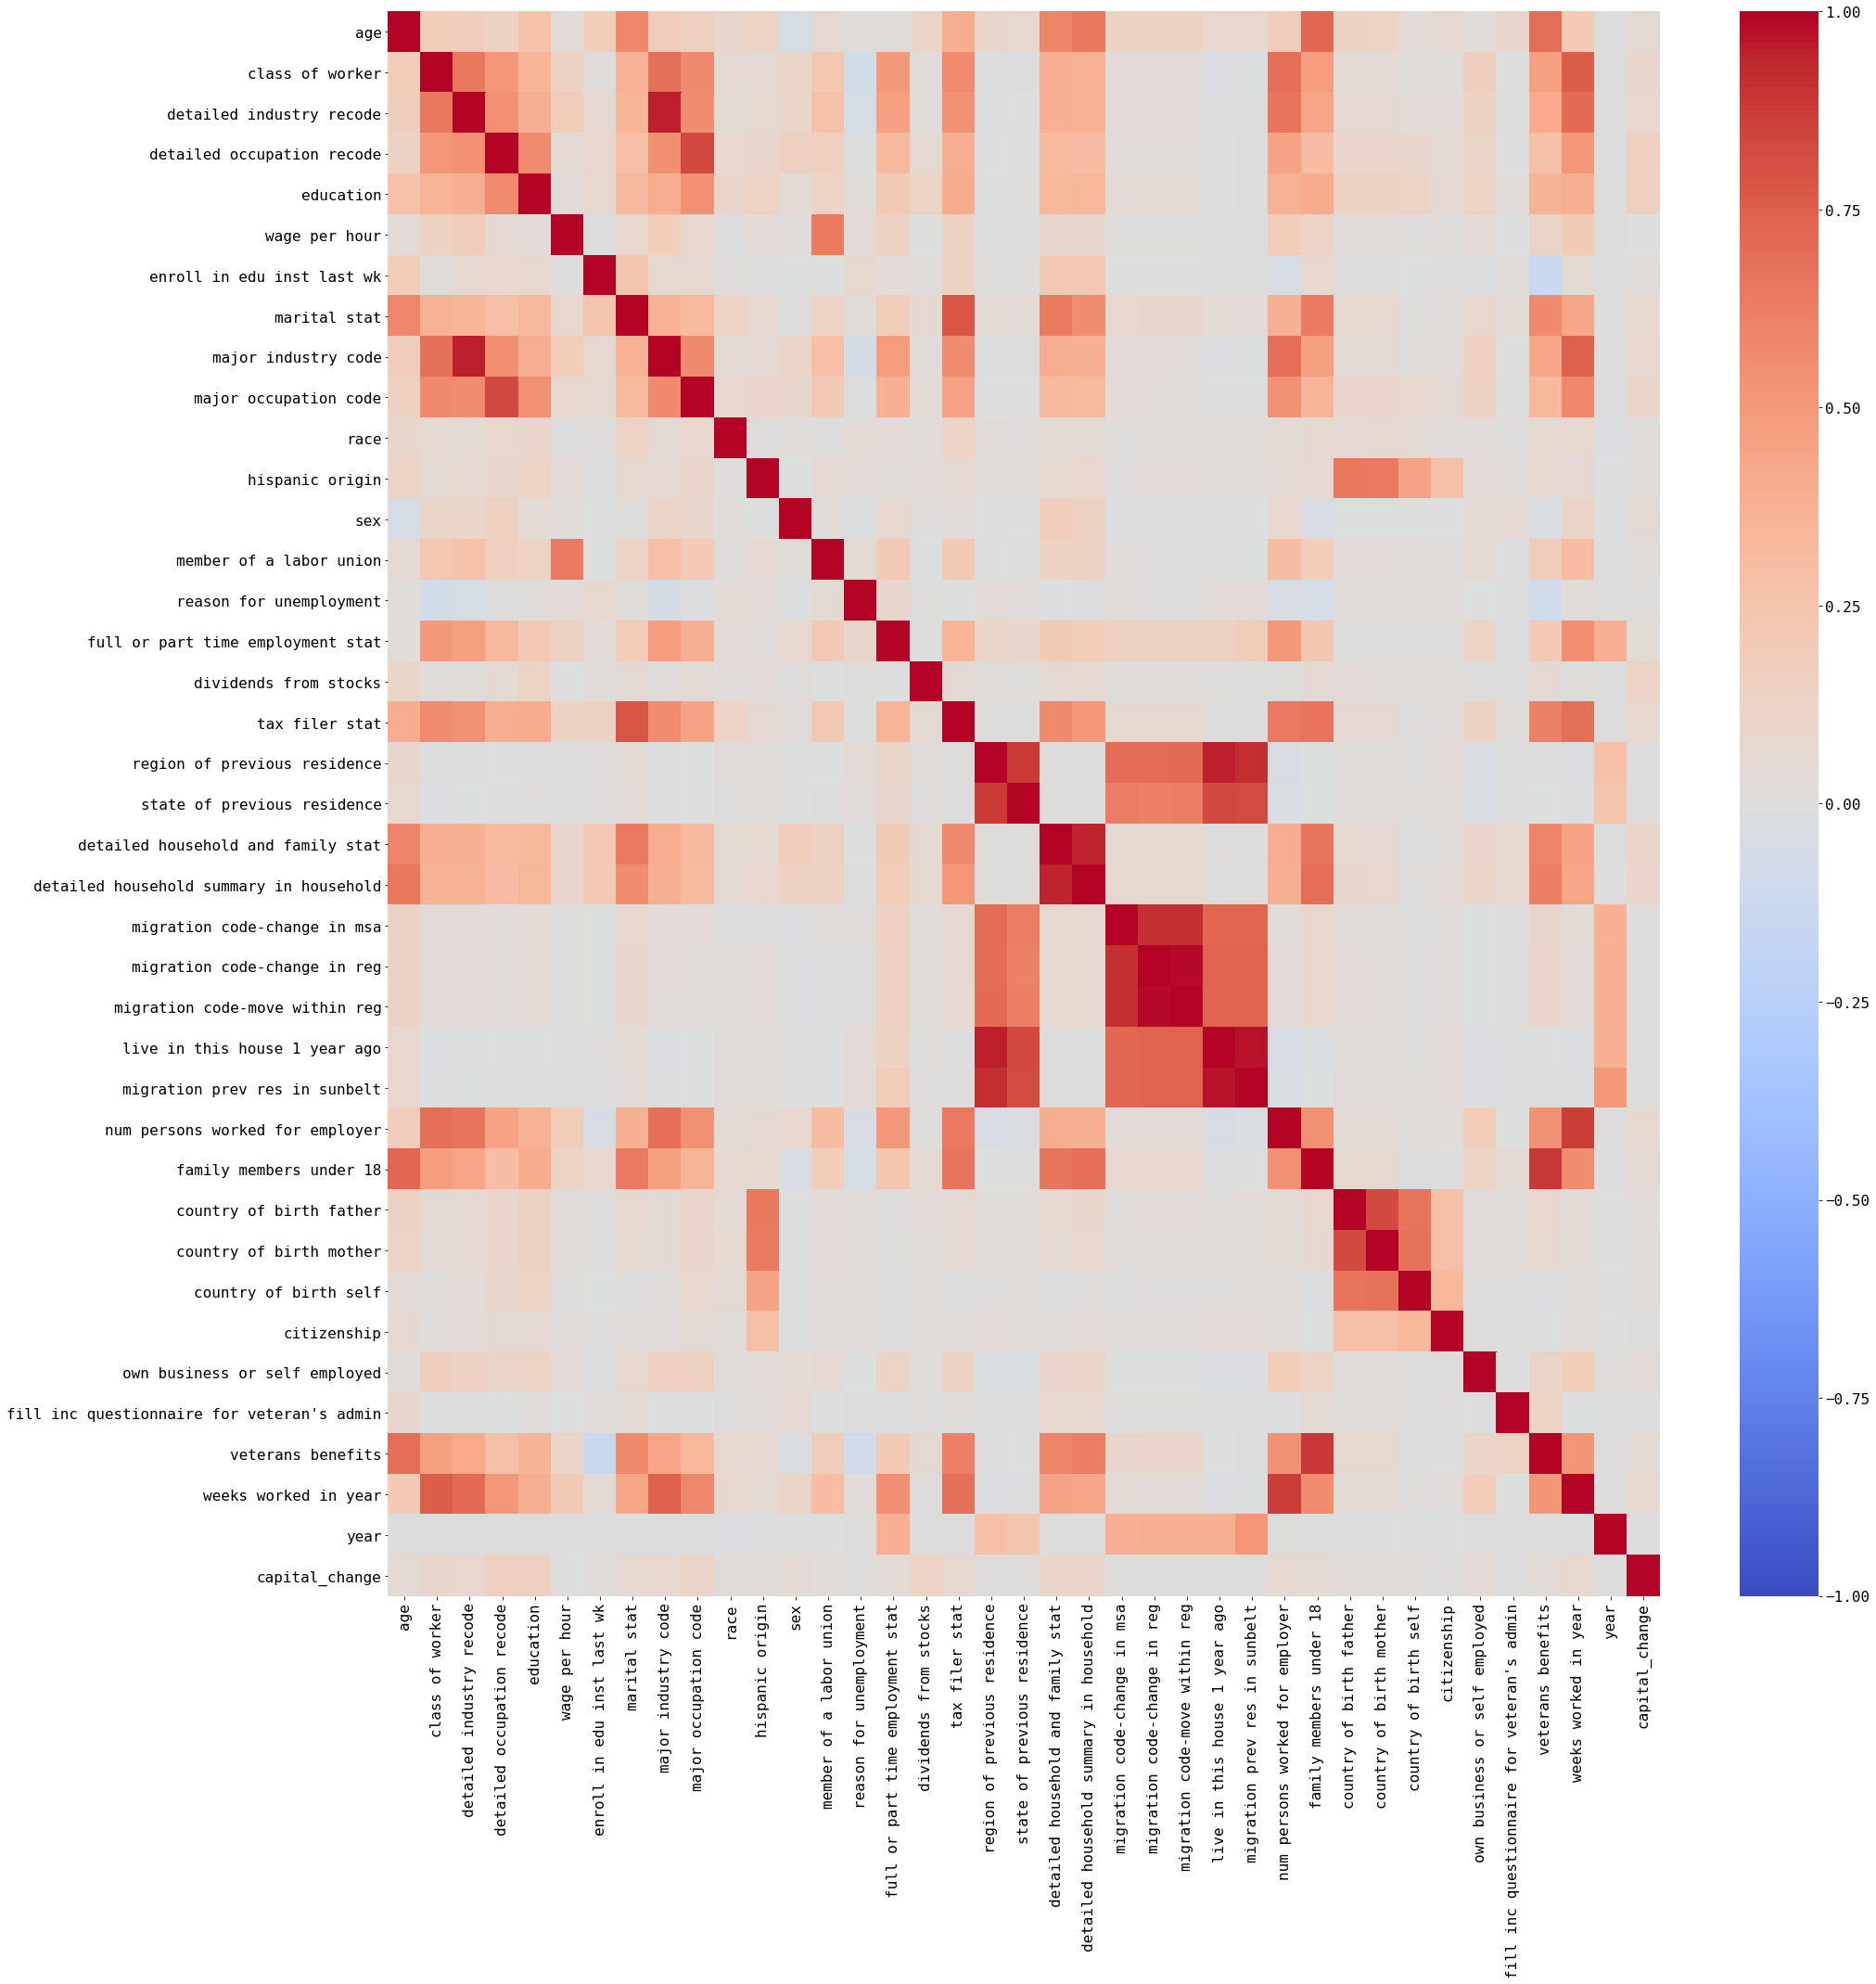

In [21]:
eda.corr_details()

# Model Building

In [60]:
RANDOM_SEED = 42

class Modeling:

    X_train_resampled: pd.DataFrame
    y_train_resampled: pd.Series

    X_train_overfit: pd.DataFrame
    y_train_overfit: pd.Series

    X_test: pd.DataFrame
    y_test: pd.Series
    y_hat: np.array
    y_hat_proba: np.ndarray

    model_precision: np.ndarray
    model_recall: np.ndarray
    model_fpr: np.ndarray
    model_tpr: np.ndarray

    selected_model: Union[RandomForestClassifier, SVC, XGBClassifier, LogisticRegression, KNeighborsClassifier]

    training_results_df: pd.DataFrame

    current_datetime = datetime.now().strftime('%m%d%Y_%H%M%S')

    clfs= {'random_forest': RandomForestClassifier(n_jobs=-1),
           'svm_clf': SVC(max_iter=300, probability=True),
           'xgboost': XGBClassifier(n_jobs=-1, use_label_encoder=False),
           'logistic': LogisticRegression(n_jobs=-1),
           'knn': KNeighborsClassifier(n_jobs=-1)}
    n_clfs: int = len(clfs)
    clf_list = list(clfs.keys())

    search_space = {'random_forest': {'n_estimators': [10, 100, 500], 'max_features': [2, 4, 6]},
                    'svm_clf': {'C': [.01, .1, 1, 10], 'kernel': ['rbf', 'linear', 'poly']},
                    'xgboost': {'n_estimators': [100, 500, 1000], 'max_depth': [2, 4, 6, 8, 10]},
                    'logistic': {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.1, 0.5, 0.8], 'warm_start': [True, False]},
                    'knn': {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}}

    def __init__(self, eda: EDA):
        self.X_train, self.y_train = eda.X_train, eda.y_train
        self.X_test, self.y_test = eda.X_test, eda.y_test

    def perform_resampling(self, downsampling: bool = False, down_ratio: float = 1.0, up_ratio: float = 0.5):
        X_cols = self.X_train.columns
        if downsampling:
            smote = SMOTE(sampling_strategy=up_ratio)
            undersampler = RandomUnderSampler(sampling_strategy=down_ratio)
            pipeline = Pipeline(steps=[('smote', smote), ('undersampler', undersampler)])

        else:
            smote = SMOTE()
            pipeline = Pipeline(steps=[('smote', smote)])

        X, y = pipeline.fit_resample(self.X_train, self.y_train)
        self.X_train_resampled, self.y_train_resampled = pd.DataFrame(X, columns=X_cols), pd.Series(y, name='target')
        print('Resampling completed.')

        val_counts_before = self.y_train.value_counts()
        val_counts_after = self.y_train_resampled.value_counts()

        mpl.rc('font', **LARGE_FONT)
        fig, ax = plt.subplots(1, 2, figsize=(30,10), sharey=True)
        fig.suptitle('Resampled class distribution')
        ax_titles = ['Before resampling', 'After resampling']

        for i, vals in enumerate([val_counts_before, val_counts_after]):
            sns.barplot(x=['<50k', '>=50k'], y=vals.values, ax=ax[i])
            ax[i].set_title(ax_titles[i])

        def show_values_on_bars(axs):
            def _show_on_single_plot(ax):
                for p in ax.patches:
                    _x = p.get_x() + p.get_width() / 2
                    _y = p.get_y() + p.get_height()
                    value = '{:.0f}'.format(p.get_height())
                    ax.text(_x, _y*1.01, value, ha="center")

            if isinstance(axs, np.ndarray):
                for idx, ax in np.ndenumerate(axs):
                    _show_on_single_plot(ax)
            else:
                _show_on_single_plot(axs)

        show_values_on_bars(ax)
        plt.tight_layout()
        plt.show()
        
    def train_model(self, overfit_test: bool = False, random_seed: int = RANDOM_SEED):
        if overfit_test:
            seed(random_seed)
            random_values = randint(0, len(self.y_train_resampled), 100)
            self.X_train_resampled, self.y_train_resampled = self.X_train_resampled.iloc[random_values], self.y_train_resampled.iloc[random_values]

        if not os.path.isdir(f'./trained_models/{self.current_datetime}'): os.mkdir(f'./trained_models/{self.current_datetime}')

        cv_outer = KFold(n_splits=self.n_clfs, shuffle=True)
        cv_inner = KFold(n_splits=5, shuffle=True)
        results = {}

        i = 0
        for train_ix, test_ix in cv_outer.split(self.X_train_resampled):

            X_train, X_test = self.X_train_resampled.iloc[train_ix], self.X_train_resampled.iloc[test_ix]
            y_train, y_test = self.y_train_resampled.iloc[train_ix], self.y_train_resampled.iloc[test_ix]

            model_training_start = time.time()
            model = self.clfs[self.clf_list[i]]

            search_space = self.search_space[self.clf_list[i]]
            search = GridSearchCV(model, search_space, scoring='roc_auc', cv=cv_inner, refit=True, n_jobs=-1)

            result = search.fit(X_train, y_train, eval_metric='logloss') if self.clf_list[i] in ['xgboost'] else search.fit(X_train, y_train)
            best_model = result.best_estimator_
            if not overfit_test: joblib.dump(best_model, f'./trained_models/{self.current_datetime}/{self.clf_list[i]}.pkl')

            y_hat = best_model.predict(X_test)
            roc_auc_test = roc_auc_score(y_test, y_hat)
            model_training_time = time.time() - model_training_start
            results[f'{self.clf_list[i]}'] = [roc_auc_test, result.best_score_, result.best_params_, model_training_time, np.nan]
            print(f'>{self.clf_list[i]} training complete, time elapsed={model_training_time}')

            i+=1

        self.training_results_df = pd.DataFrame.from_dict(results, orient='index', columns=['k-fold test roc_auc', 'k-fold validation roc_auc', 'hyperparams', 'training time', 'test set pr_auc'])
        training_results_df_sorted = self.training_results_df.sort_values('k-fold test roc_auc', ascending=False)
        display(training_results_df_sorted)

        if not overfit_test:
            selected_model_name = training_results_df_sorted.index[0]
            print(f'The model with the highest nested k-fold cross validation score is: {selected_model_name}. This will be our selected model.')
            self.selected_model = joblib.load(f'./trained_models/{self.current_datetime}/{selected_model_name}.pkl')


    def test_set_eval(self):
        model_list = [f'./trained_models/{self.current_datetime}/{self.clf_list[i]}.pkl' for i in range(self.n_clfs)]
        results = []

        for i, models in enumerate(model_list):
            with open(models, 'rb') as f:
                model = joblib.load(f)
                
            y_hat = model.predict(self.X_test)
            y_hat_proba = model.predict_proba(self.X_test)[:, 1]
            
            model_precision, model_recall, _ = precision_recall_curve(self.y_test, y_hat_proba)            
            pr_auc = auc(model_recall, model_precision)
            results.append(pr_auc)

        self.training_results_df['test set pr_auc'] = results
        training_results_cols = [self.training_results_df.columns[-1]] + list(self.training_results_df.columns[:-1])
        self.training_results_df = self.training_results_df[training_results_cols]
        display(self.training_results_df.sort_values('k-fold test roc_auc', ascending=False))

        self.training_results_df.to_csv(f'./trained_models/{self.current_datetime}/train_test_results.csv')
        
        self.y_hat = self.selected_model.predict(self.X_test)
        self.y_hat_proba = self.selected_model.predict_proba(self.X_test)[:, 1]

        self.model_precision, self.model_recall, _ = precision_recall_curve(self.y_test, self.y_hat_proba)
        self.model_fpr, self.model_tpr, _ = roc_curve(self.y_test, self.y_hat_proba)

The next few cells give you an idea of the resampling approaches we can use to balance the data classes.  We can use oversampling alone or a combination of both over and undersampling to perform this task

Resampling completed.


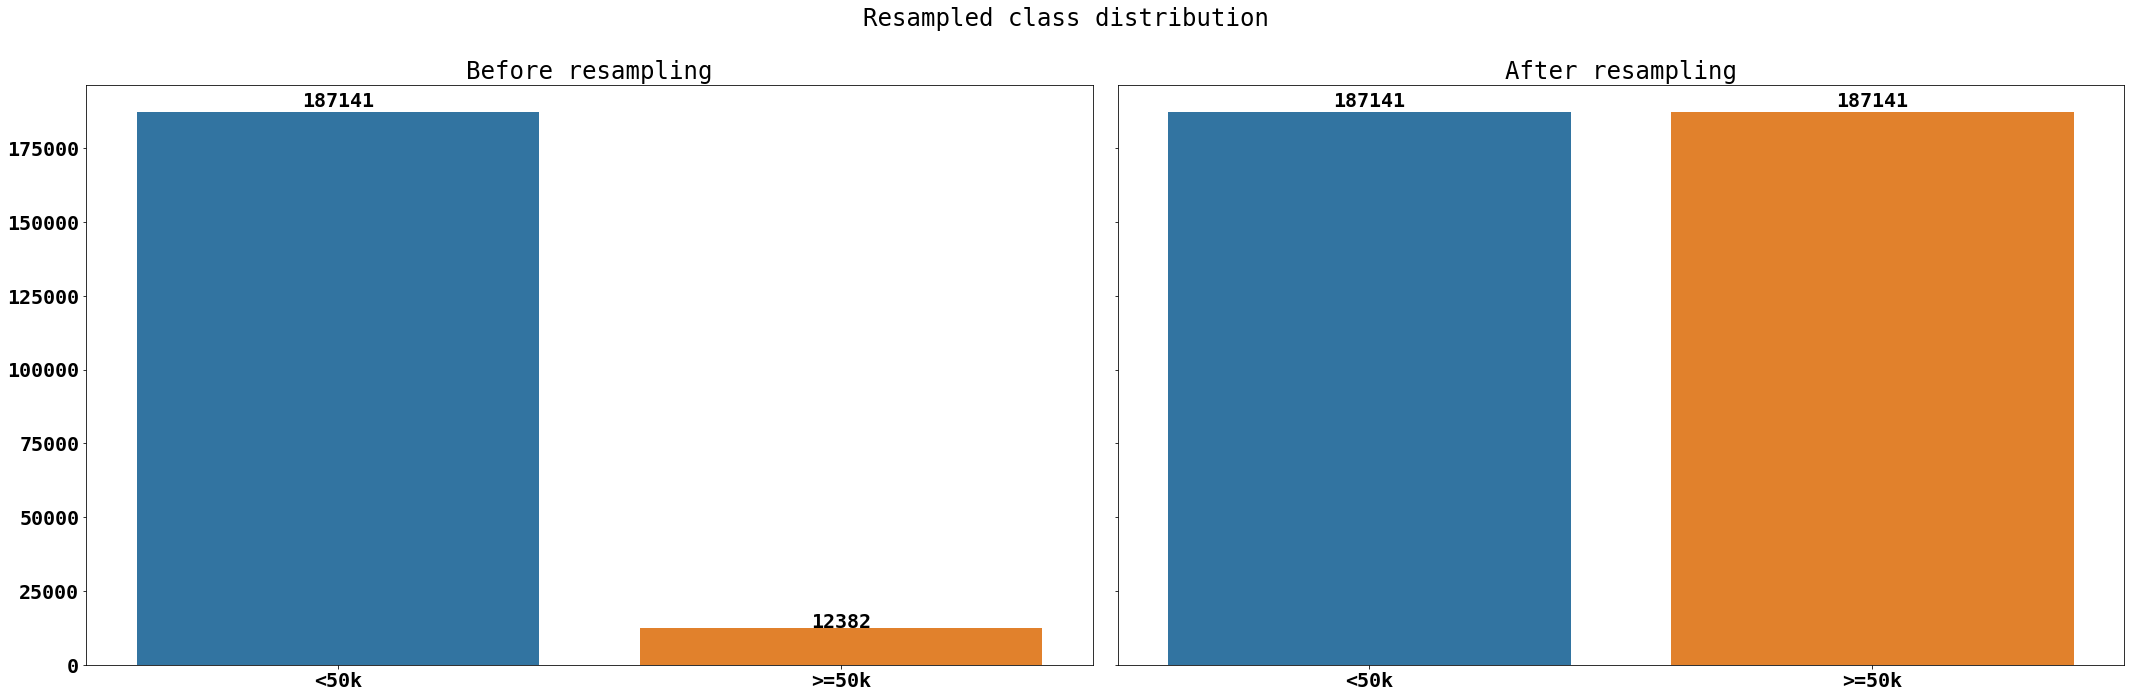

In [32]:
resampling_methods1 = Modeling(eda)
resampling_methods1.perform_resampling()

Resampling completed.


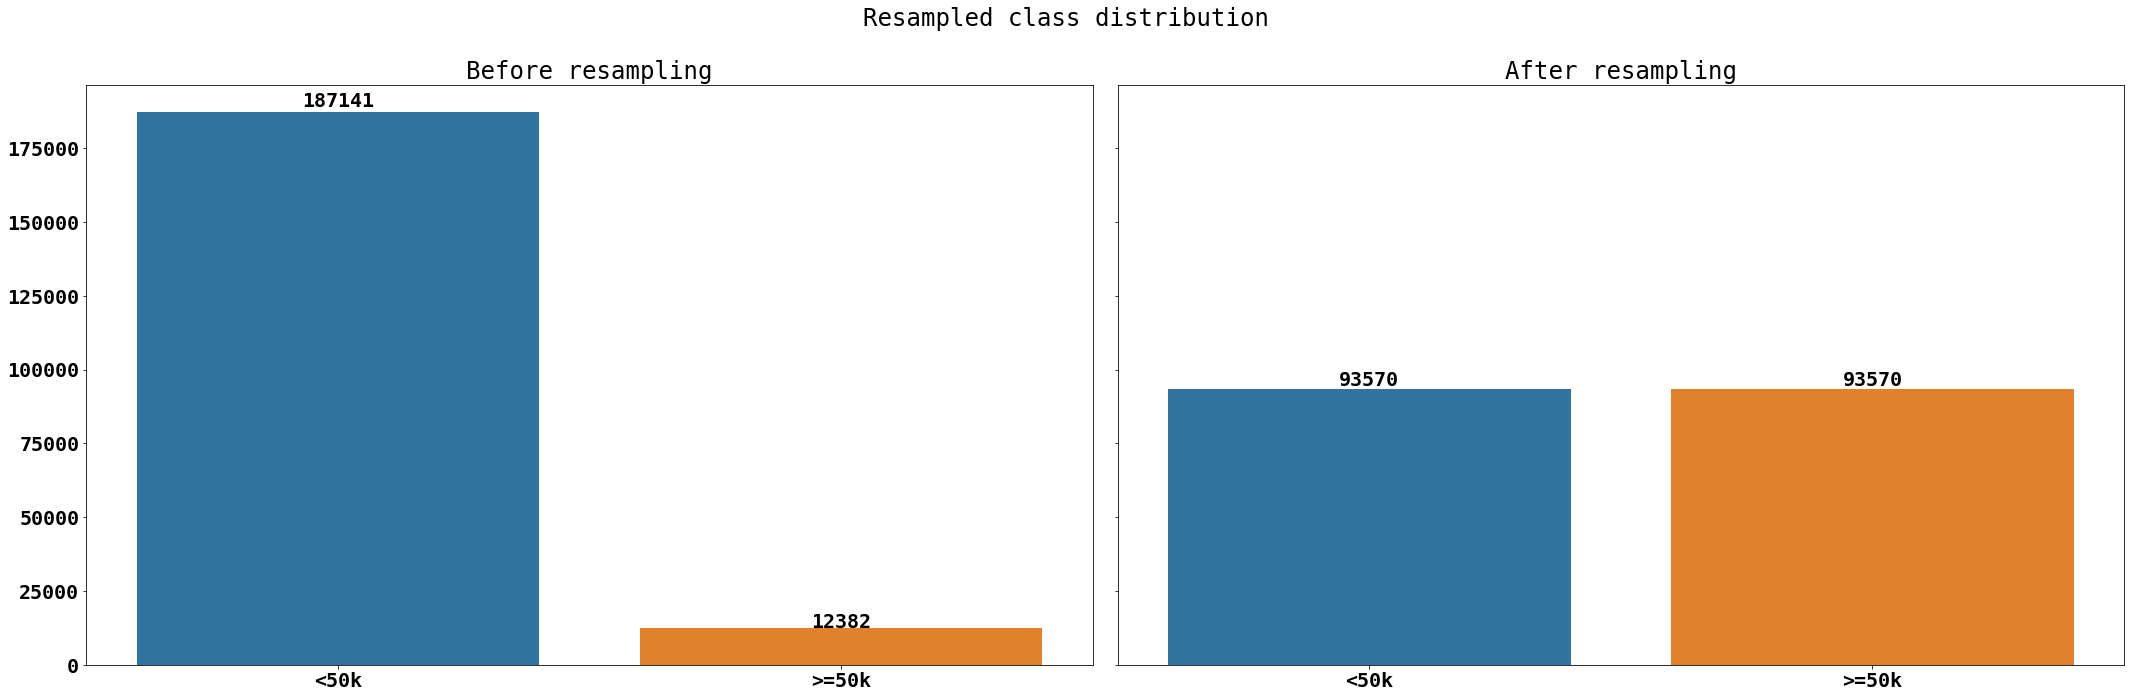

In [33]:
resampling_methods2 = Modeling(eda)
resampling_methods2.perform_resampling(downsampling=True, down_ratio=1.0, up_ratio=0.5)

Resampling completed.


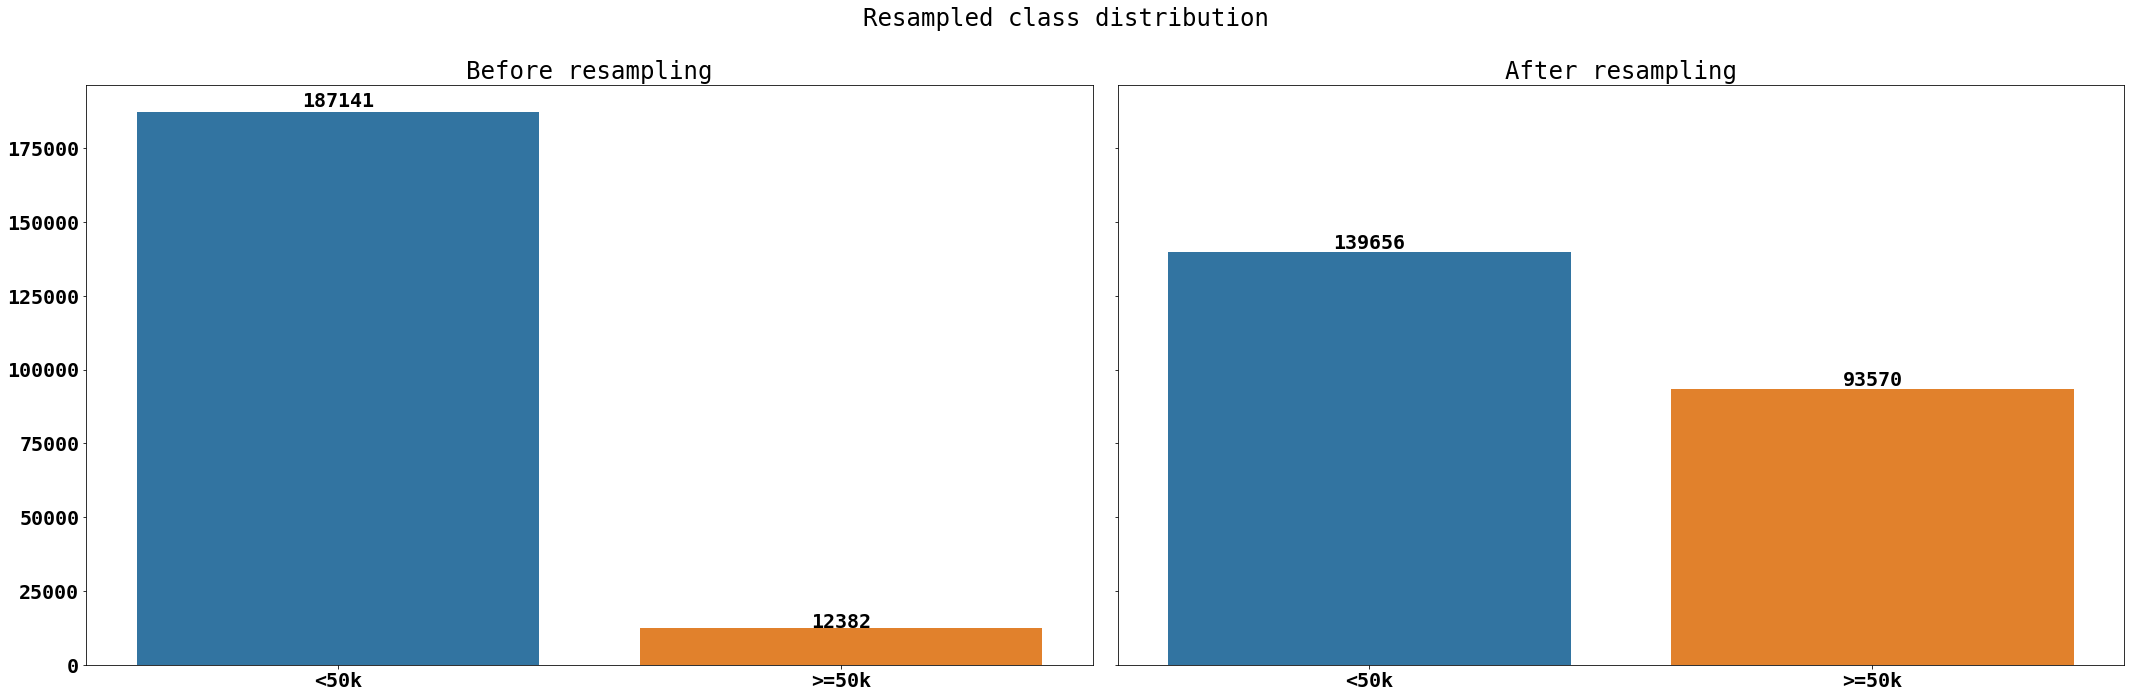

In [34]:
resampling_methods3 = Modeling(eda)
resampling_methods3.perform_resampling(downsampling=True, down_ratio=0.67, up_ratio=0.5)

Next, an overfit test will be performed, where a small sample of the data is randomly selected from the resampled dataset and the models are trained on that data.  This test just ensures that everything in the training loop is working correctly

Resampling completed.


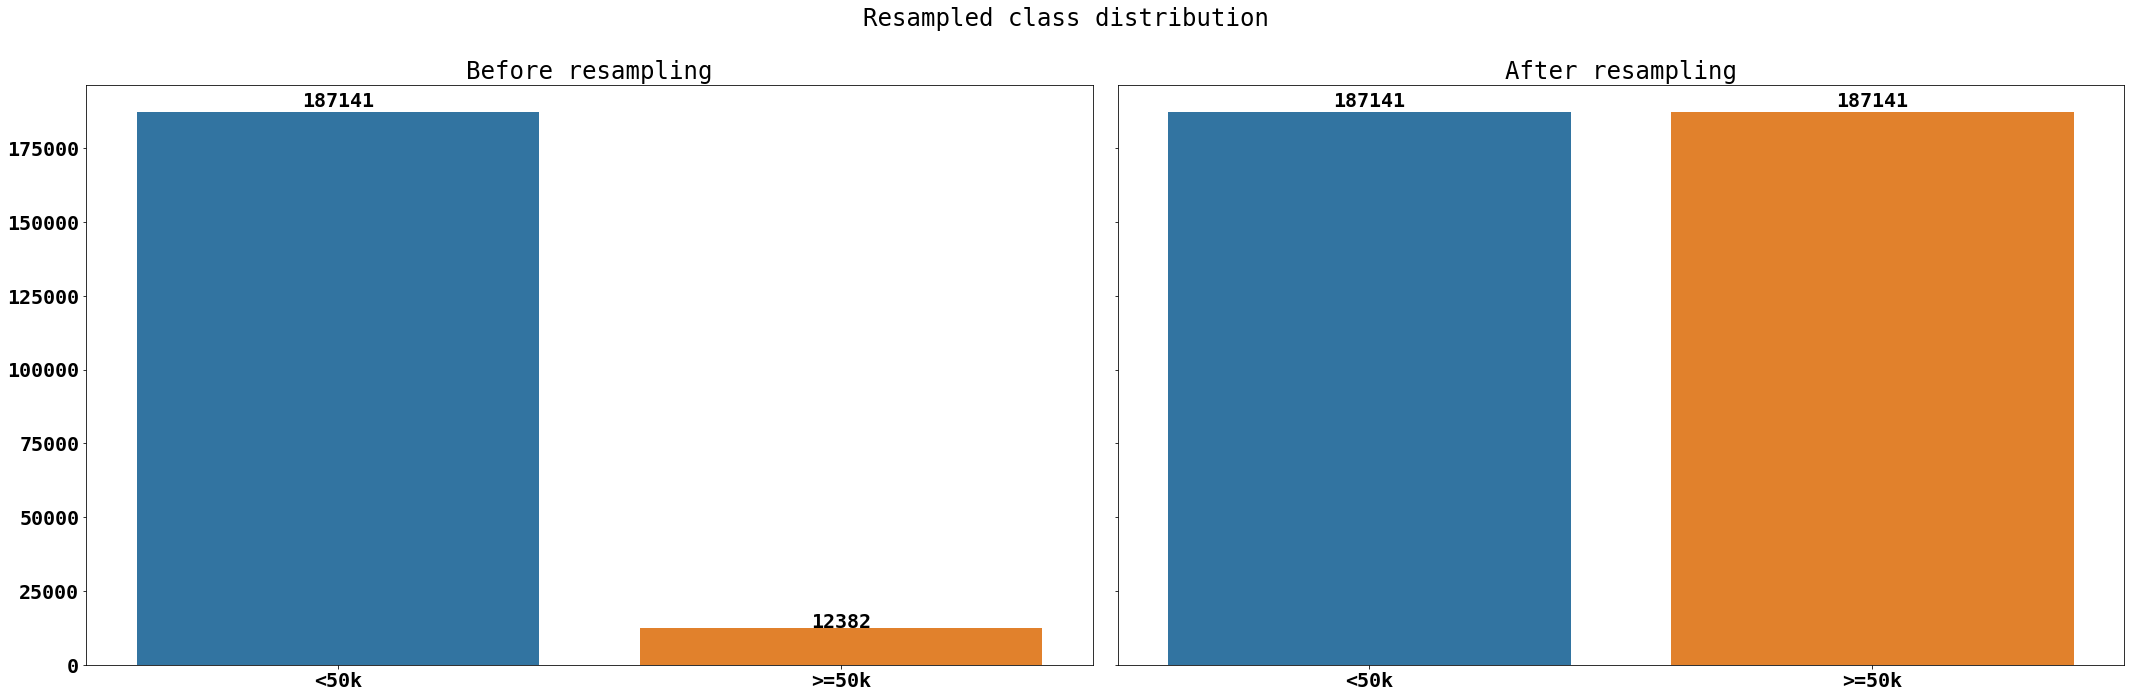

In [61]:
overfit_test = Modeling(eda)
overfit_test.perform_resampling()

In [62]:
overfit_test.train_model(overfit_test=True, random_seed=0)

>random_forest training complete, time elapsed=2.0916945934295654
>svm_clf training complete, time elapsed=0.136002779006958
>xgboost training complete, time elapsed=5.461309432983398
>logistic training complete, time elapsed=4.914515495300293
>knn training complete, time elapsed=0.3362753391265869


,k-fold test roc_auc,k-fold validation roc_auc,hyperparams,training time,test set pr_auc
random_forest,0.950,0.916,"{'max_features': 2, 'n_estimators': 100}",2.092,NaN
logistic,0.833,0.893,"{'C': 0.5, 'penalty': 'l2', 'warm_start': True}",4.915,NaN
svm_clf,0.773,0.880,"{'C': 1, 'kernel': 'rbf'}",0.136,NaN
xgboost,0.762,0.974,"{'max_depth': 4, 'n_estimators': 1000}",5.461,NaN
knn,0.687,0.890,"{'n_neighbors': 10, 'weights': 'distance'}",0.336,NaN


Lastly, we will now train our model on the dataset after upsampling the minority class to 1/3 the size of the majority class and then downsampling the majority class to the same size as the minority class

In [63]:
model_train = Modeling(eda)

Resampling completed.


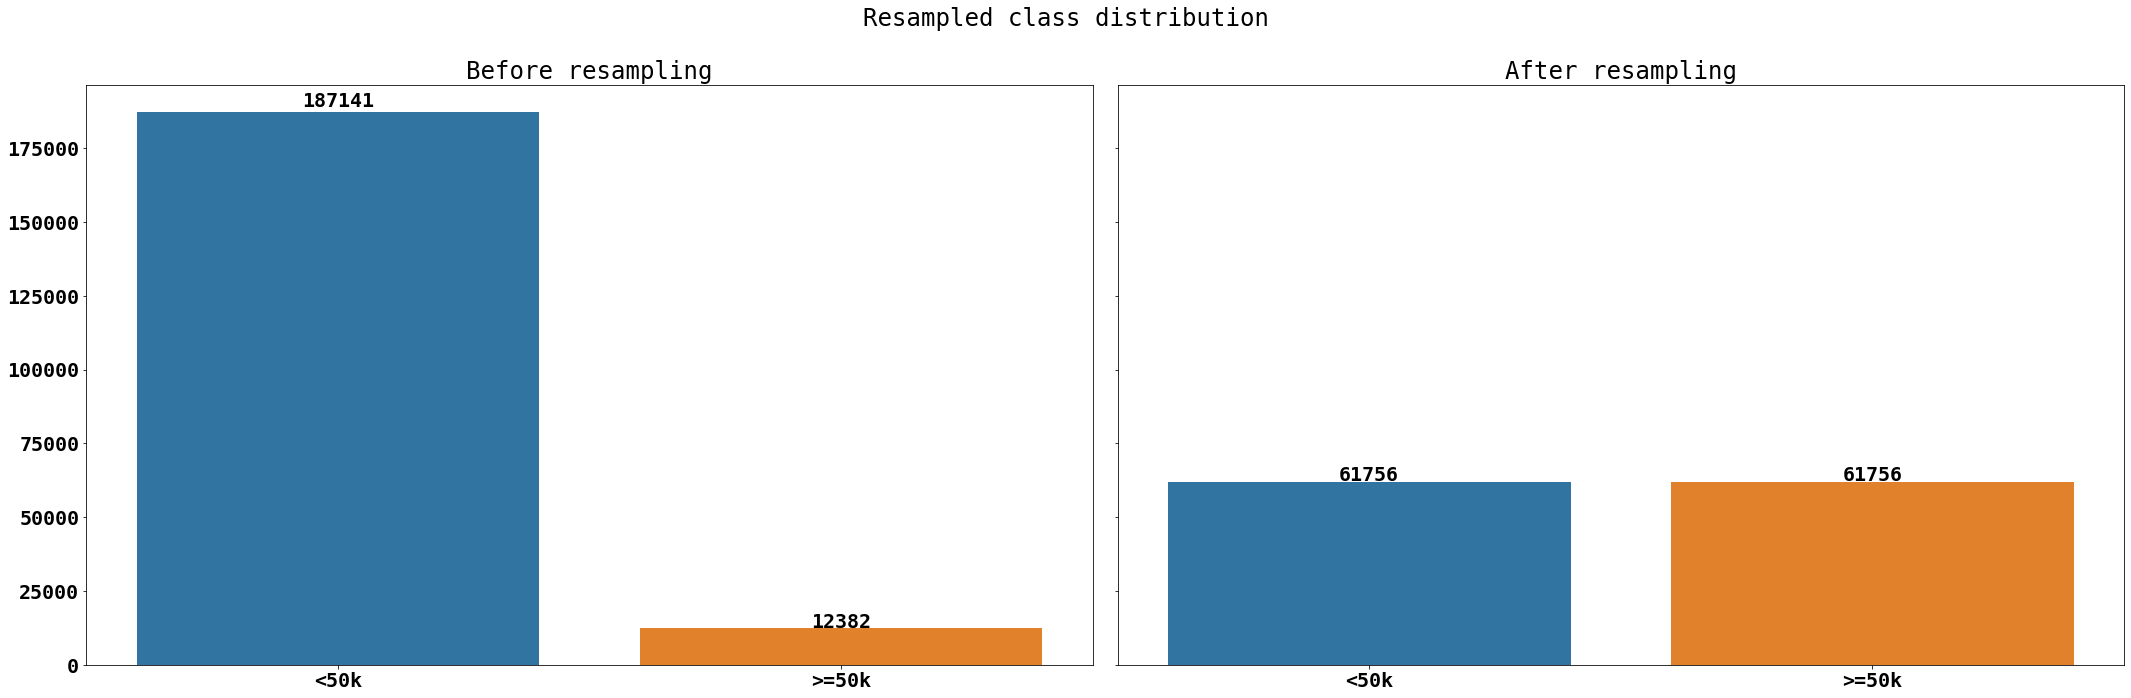

>random_forest training complete, time elapsed=54.47415852546692
>svm_clf training complete, time elapsed=143.1258578300476
>xgboost training complete, time elapsed=441.05101251602173
>logistic training complete, time elapsed=20.984147548675537
>knn training complete, time elapsed=89.76660346984863


,k-fold test roc_auc,k-fold validation roc_auc,hyperparams,training time,test set pr_auc
xgboost,0.949,0.990,"{'max_depth': 2, 'n_estimators': 1000}",441.051,NaN
random_forest,0.946,0.988,"{'max_features': 2, 'n_estimators': 500}",54.474,NaN
knn,0.909,0.967,"{'n_neighbors': 10, 'weights': 'distance'}",89.767,NaN
logistic,0.872,0.941,"{'C': 0.8, 'penalty': 'l2', 'warm_start': True}",20.984,NaN
svm_clf,0.483,0.783,"{'C': 1, 'kernel': 'linear'}",143.126,NaN


The model with the highest nested k-fold cross validation score is: xgboost. This will be our selected model.


In [64]:
model_train.perform_resampling(downsampling=True, down_ratio=1.0, up_ratio=0.33)
model_train.train_model()

Although we have selected xgboost as our final model, I still like to run the test set through all of the candidate model just to get an understanding of possible overfitting 

In [65]:
model_train.test_set_eval()

,test set pr_auc,k-fold test roc_auc,k-fold validation roc_auc,hyperparams,training time
xgboost,0.543,0.949,0.990,"{'max_depth': 2, 'n_estimators': 1000}",441.051
random_forest,0.456,0.946,0.988,"{'max_features': 2, 'n_estimators': 500}",54.474
knn,0.547,0.909,0.967,"{'n_neighbors': 10, 'weights': 'distance'}",89.767
logistic,0.579,0.872,0.941,"{'C': 0.8, 'penalty': 'l2', 'warm_start': True}",20.984
svm_clf,0.301,0.483,0.783,"{'C': 1, 'kernel': 'linear'}",143.126


# Results Analysis

In [54]:
class Results:

    def __init__(self, model_train: Modeling):
        self.model = model_train.selected_model
        self.precision, self.recall = model_train.model_precision, model_train.model_recall
        self.fpr, self.tpr = model_train.model_fpr, model_train.model_tpr
        self.X_test, self.y_test, self.y_hat = model_train.X_test, model_train.y_test, model_train.y_hat


    def confusion_matrix(self):
        self.cf_matrix = confusion_matrix(self.y_test, self.y_hat)
        self.cf_matrix = np.asarray(self.cf_matrix)

        diagonal_values = [self.cf_matrix[i][i] for i in range(2)]
        self.classifier_accuracy = sum(diagonal_values) / len(self.y_test)

        fig, ax = plt.subplots(figsize=(8,8))
        _ = ax.imshow(self.cf_matrix, cmap='Blues')

        ax.set_title('Confusion Matrix')
        fig.tight_layout()

        ax.set_xlabel('Predicted labels'), ax.set_ylabel('Actual labels')
        ax.set_xticks(range(2)), ax.set_yticks(range(2))
        ax.set_xticklabels(['<50k', '>=50k']), ax.set_yticklabels(['<50k', '>=50k'])

        text_colors = ['k', 'w']
        text_color_threshold = 25000
        for i in range(2):
            for j in range(2):
                _ = ax.text(j, i, self.cf_matrix[i, j], ha="center", va="center", color=text_colors[self.cf_matrix[i, j] > text_color_threshold])

    def pr_curve(self):
        mpl.rc('font', **SMALL_FONT)

        display = PrecisionRecallDisplay(precision=self.precision, recall=self.recall)
        display.plot()
        display.ax_.set_title("Precision-Recall curve")
        display.ax_.set_xlabel('Recall'), display.ax_.set_ylabel('Precision')

        plt.tight_layout()
        plt.show()
        
        print(f'P-R curve AUC: {auc(self.recall, self.precision)}')
        
    def roc_curve(self):
        mpl.rc('font', **SMALL_FONT)

        display = RocCurveDisplay(fpr=self.fpr, tpr=self.tpr)
        display.plot()
        display.ax_.set_title("Receiver Operating Characteristic curve")
        display.ax_.set_xlabel('False Positive Rate'), display.ax_.set_ylabel('True Positive Rate')

        plt.tight_layout()
        plt.show()
        
        print(f'ROC curve AUC: {auc(self.fpr, self.tpr)}')
        
    def display_feature_importance(self):
        mpl.rc('font', **LARGE_FONT)
        
        features, importances = self.X_test.columns, np.round(self.model.feature_importances_,3)

        fig, ax = plt.subplots(figsize=(30,20))
        bar = sns.barplot(x=self.X_test.columns, y=self.model.feature_importances_, ax=ax)
        bar.set_xticklabels(bar.get_xticklabels(), rotation=60, horizontalalignment='right')

        plt.tight_layout()
        plt.show()

        feature_importance_df = pd.DataFrame(columns=['importance'], index=features)
        feature_importance_df['importance'] = importances
        display(feature_importance_df.sort_values('importance', ascending=False).head(15))

In [55]:
results = Results(model_train=model_train)

First, we will have a look at the confusion matrix, which shows the counts for all the positive and negative predictions with respect to the positive and negative actual labels.  This matrix contains all the data we're looking for in order to compute various other useful evaluation metrics like precision, recall, and accuracy.

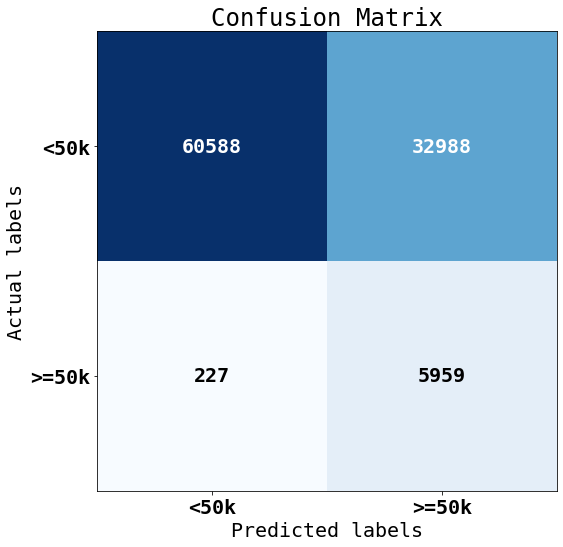

In [56]:
results.confusion_matrix()

Next, we will look at the Precision-Recall (P-R) curve for our selected model.  This curve is more sensitive to imbalanced target classes than ROC.  The area under the curve, or AUC, is the quantitative metric associated with this curve that can provide numerical understanding.  P-R AUC ranges from [0, 1].

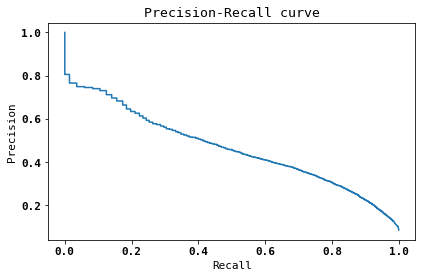

P-R curve AUC: 0.4691716624881008


In [57]:
results.pr_curve()

It can still be worthwhile to examine the Receiver Operating curve (ROC), just don't take too much stock in it.  Because of the huge number of minority samples in the test set, the AUC of this curve can often be falsely inflated simply due to the math that defines the curve.

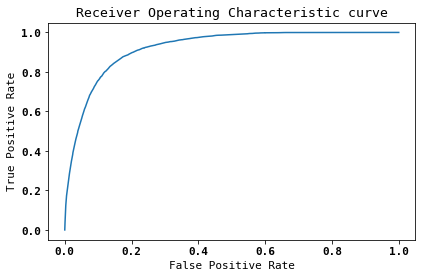

ROC curve AUC: 0.9226072244034706


In [58]:
results.roc_curve()

Lastly, we can take a look at the metric the prompt targeted as our desire information: the feature importance of the model.  This graph displays the numerical values for how much each feature influences the predictions of the model, ranging from [0, 1].  The most important features according to this calculation are: 1) , 2) , 3) 

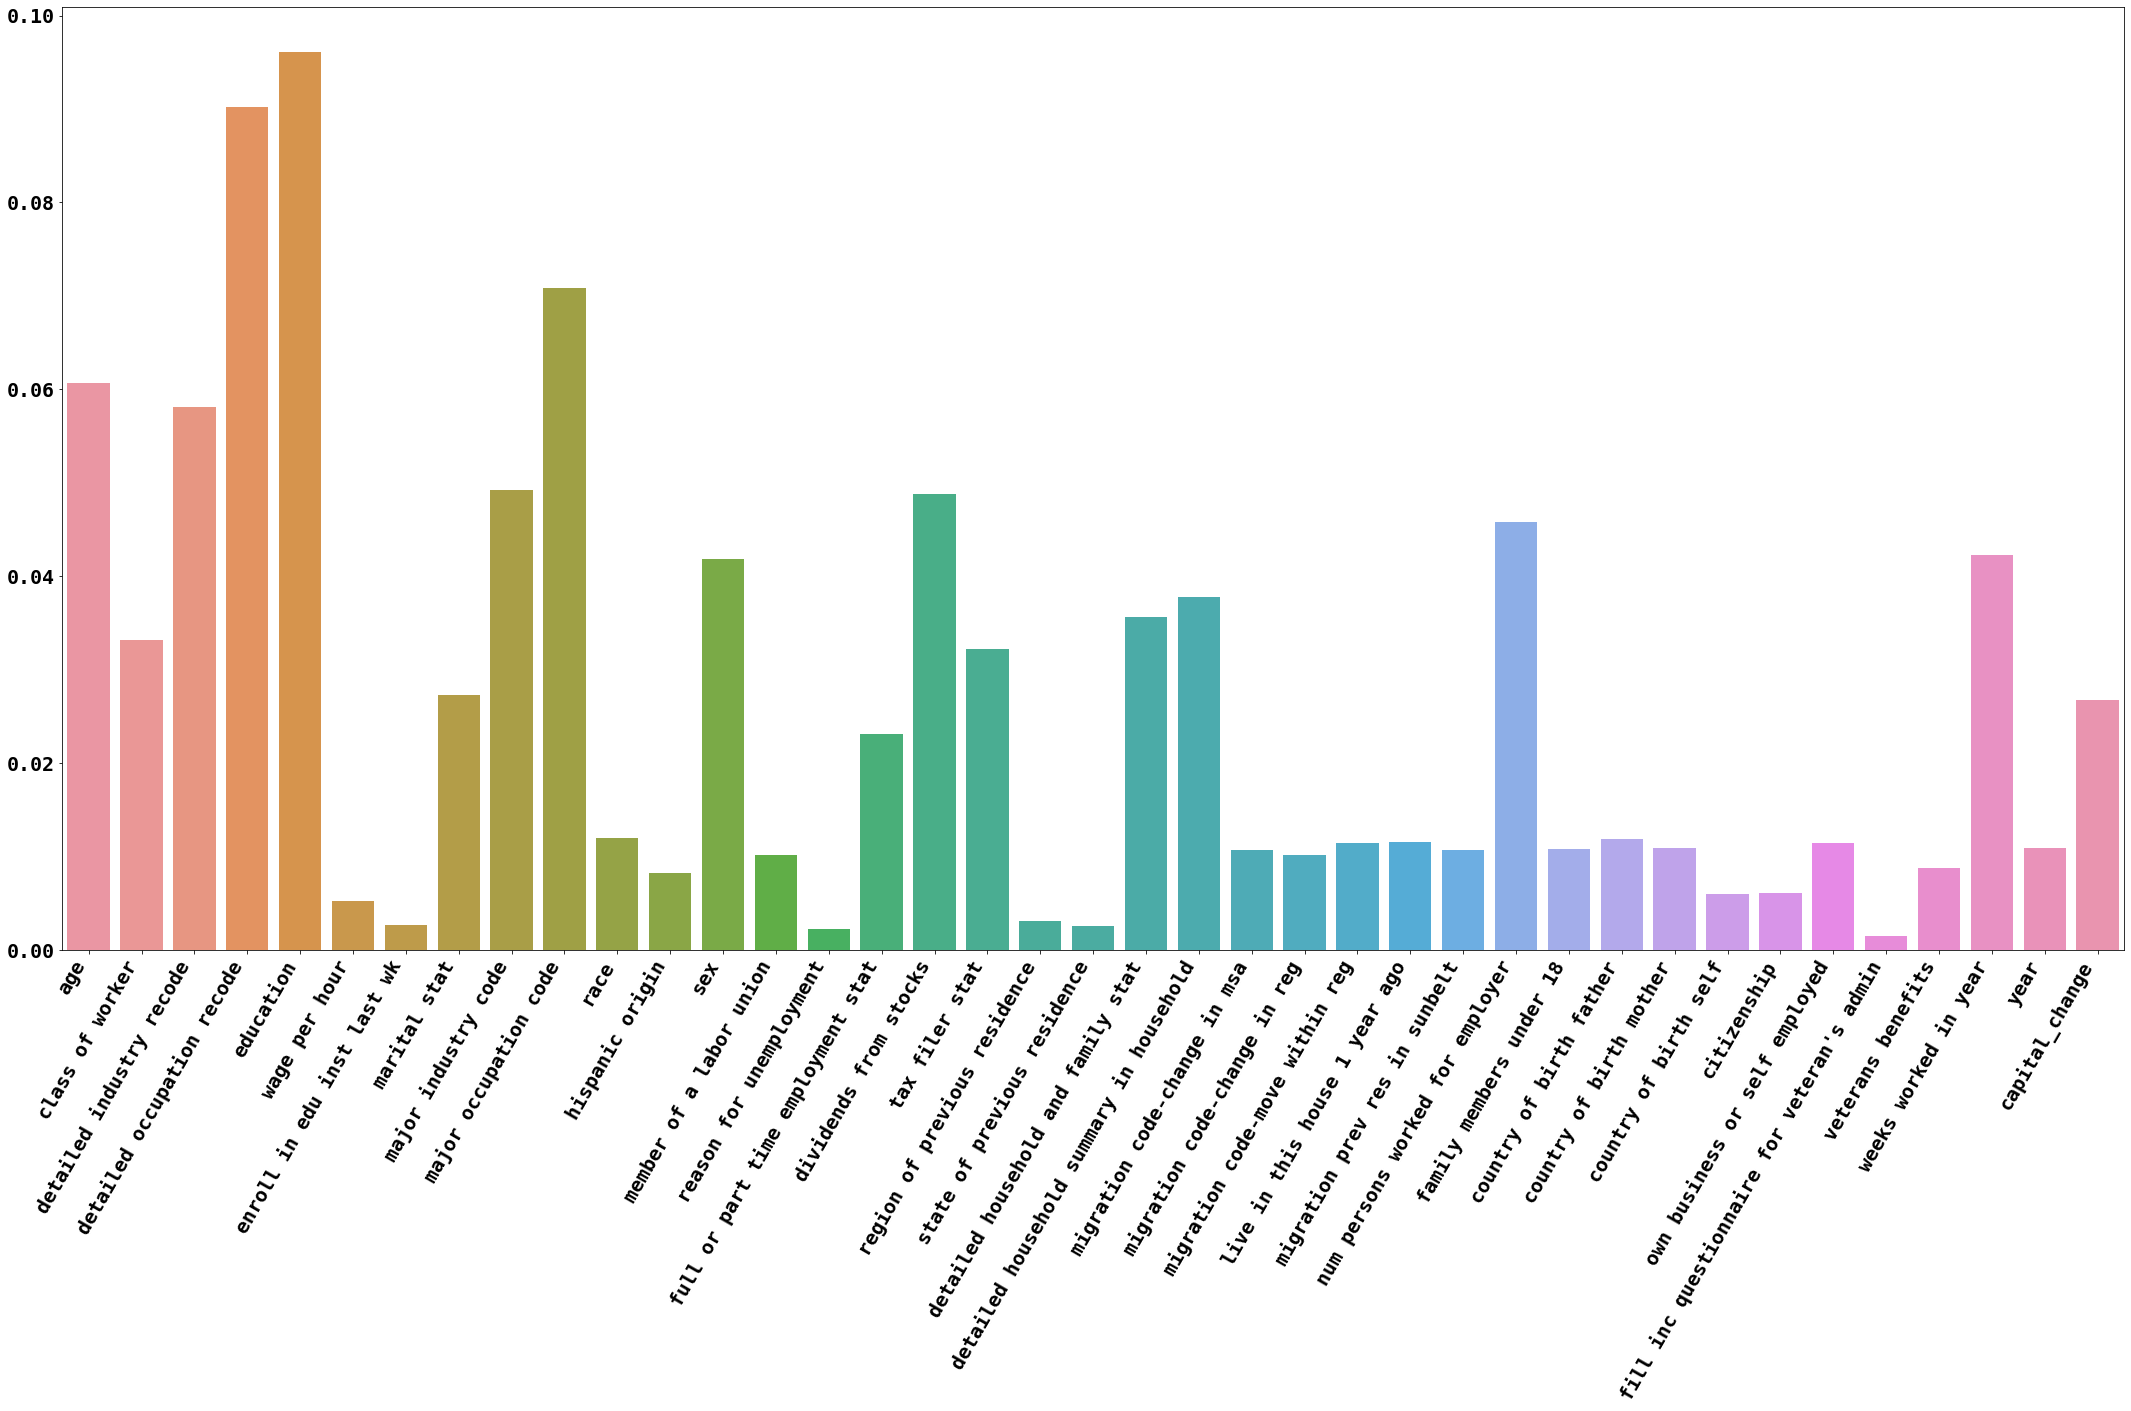

,importance
education,0.096
detailed occupation recode,0.090
major occupation code,0.071
age,0.061
detailed industry recode,0.058
dividends from stocks,0.049
major industry code,0.049
num persons worked for employer,0.046
weeks worked in year,0.042
sex,0.042


In [59]:
results.display_feature_importance()